In [1]:
import time
import static
from difflib import get_close_matches
from scipy.sparse import triu
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from collections import Counter
from itertools import combinations
import itertools
from datetime import datetime
import networkx as nx
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis.lda_model
import re
from scholarly import scholarly
import requests
import glob
import bibtexparser
from tqdm.notebook import tqdm
from bs4 import BeautifulSoup
import requests
import re

# Campos de df base

In [2]:
fields = [
    "fuente", "authors", "author_full_names", "author_id", "title", "year", "source_title", "volume", "issue",
    "art", "page_start", "page_end", "page_count", "cited_by", "DOI", "link", "abstract", "author_keywords",
    "index_keywords", "document_type", "publication_stage", "open_access", "source", "EID", "h_index_autor","h_index_revista", "cuartil" 
]

# Busqueda en bases de datos academicas

## Scopus

In [3]:
# Importar el archivo CSV exportado desde Scopus
scopus_df = pd.read_csv("./csv/scopus.csv", delimiter=',')
print("Dimensiones del archivo Scopus:", scopus_df.shape)

Dimensiones del archivo Scopus: (165, 41)


In [4]:
# --- Mapeo automático de nombres de columnas ---
def auto_column_map(fields, columns, cutoff=0.7):
    mapping = {}
    for f in fields:
        match = get_close_matches(f, columns, n=1, cutoff=cutoff)
        if match:
            mapping[match[0]] = f       
    return mapping
column_map = auto_column_map(fields, scopus_df.columns)
print("Mapeo detectado:")
for k, v in column_map.items():
    print(f"{k} -> {v}")
scopus_df_renamed = scopus_df.rename(columns=column_map)
scopus_df_filtered = scopus_df_renamed[[col for col in fields if col in scopus_df_renamed.columns]]

Mapeo detectado:
Authors -> authors
Author full names -> author_full_names
author_id -> author_id
Title -> title
Year -> year
Source title -> source_title
Volume -> volume
Issue -> issue
art -> art
page_start -> page_start
page_end -> page_end
Page count -> page_count
Cited by -> cited_by
DOI -> DOI
Link -> link
Abstract -> abstract
Author Keywords -> author_keywords
Index Keywords -> index_keywords
Document Type -> document_type
Publication Stage -> publication_stage
Open Access -> open_access
Source -> source
EID -> EID


In [5]:
scopus_df_filtered = scopus_df_filtered.reindex(columns=fields)
pd.set_option('display.max_columns', None)
print("Columnas finales en scopus_df_filtered:")
print(scopus_df_filtered.columns.tolist())
print("Dimensiones del DataFrame filtrado:", scopus_df_filtered.shape)
scopus_df_filtered

Columnas finales en scopus_df_filtered:
['fuente', 'authors', 'author_full_names', 'author_id', 'title', 'year', 'source_title', 'volume', 'issue', 'art', 'page_start', 'page_end', 'page_count', 'cited_by', 'DOI', 'link', 'abstract', 'author_keywords', 'index_keywords', 'document_type', 'publication_stage', 'open_access', 'source', 'EID', 'h_index_autor', 'h_index_revista', 'cuartil']
Dimensiones del DataFrame filtrado: (165, 27)


fuente                                            authors  \
0       NaN  H., Su, Huan; M., Gu, Mengli; Z., Qu, Zechao; ...   
1       NaN  I., Baek, Insuck; M., Cha, Min-hyeok; S., Lim,...   
2       NaN            L., Hssaini, Lahcen; R., Razouk, Rachid   
3       NaN       S., Prakadeswaran, S.; A.B., Banu, A. Bazila   
4       NaN  J., Sendrowski, Janek; T.M., Bataillon, Thomas...   
..      ...                                                ...   
160     NaN  T., Pal, Tarun; V.K., Jaiswal, Varun K.; R.S.,...   
161     NaN       Z., Jagga, Zeenia; D.K., Gupta, Dinesh Kumar   
162     NaN  R.A., Cernadas, Raúl Andrés; E.L., Doyle, Erin...   
163     NaN  G., Taj, Gohar; S., Sharma, Sugandha; P., Giri...   
164     NaN  G., Taj, Gohar; S., Sharma, Sugandha; P., Giri...   

                                     author_full_names  \
0    Su, Huan (58700933400); Gu, Mengli (5886674590...   
1    Baek, Insuck (55414110300); Cha, Min-hyeok (57...   
2    Hssaini, Lahcen (57209320167); Razouk, Rachid ...   
3    Prakadeswaran, S. (59671547900); Banu, A. Bazi...   
4    Sendrowski, Janek (57474084100); Bataillon, Th...   
..                                                 ...   
160  Pal, Tarun (56072559000); Jaiswal, Varun K. (5...   
161  Jagga, Zeenia (55090234900); Gupta, Dinesh Kum...   
162  Cernadas, Raúl Andrés (24586638400); Doyle, Er...   
163  Taj, Gohar (6505977631); Sharma, Sugandha (572...   
164  Taj, Gohar (6505977631); Sharma, Sugandha (572...   

                                             author_id  \
0    58700933400; 58866745900; 58701482400; 5950226...   
1    55414110300; 57193861587; 59506907800; 5720425...   
2                             57209320167; 57209323549   
3                             59671547900; 57204237495   
4                 57474084100; 6602574369; 56656272200   
..                                                 ...   
160              56072559000; 55631491500; 57203233905   
161                           55090234900; 57203635807   
162  24586638400; 36981567200; 6507159566; 37027620...   
163  6505977631; 57213924326; 56649852900; 16145737...   
164  6505977631; 57213924326; 56649852900; 16145737...   

                                                 title  year  \
0    Discovery of antimicrobial peptides from Bacil...  2025   
1    Integrated phenotypic analysis, predictive mod...  2025   
2    Mid-FTIR and machine learning for predicting f...  2025   
3    Gaussian regressed generative adversarial netw...  2025   
4    In silico prediction of variant effects: promi...  2025   
..                                                 ...   ...   
160  DRPPP: A machine learning based tool for predi...  2016   
161  Supervised learning classification models for ...  2014   
162  Code-Assisted Discovery of TAL Effector Target...  2014   
163  In-silico approaches for studying the MAP kina...  2013   
164  In-Silico approaches for studying the MAP kina...  2013   

                                          source_title volume issue       art  \
0    Chemical and Biological Technologies in Agricu...     12     1        35   
1                                    BMC Plant Biology     25     1      1050   
2                                  Analytical Sciences     41     9       NaN   
3             Biomedical Signal Processing and Control    106   NaN    107761   
4                     Theoretical and Applied Genetics    138     8       193   
..                                                 ...    ...   ...       ...   
160                  Computers in Biology and Medicine     78   NaN       NaN   
161                                           PLOS ONE      9     5    e97446   
162                                     PLOS Pathogens     10     2  e1003972   
163                                                NaN      1   NaN       NaN   
164                                                NaN    NaN   NaN       NaN   

     page_start  page_end  page_count  cited_by  \
0           NaN       NaN

## IEEE


In [6]:
# Importar el archivo CSV exportado desde IEEE
ieee_df = pd.read_csv("./csv/ieee.csv", delimiter=',')
print("Dimensiones del archivo IEEE:", ieee_df.shape)

Dimensiones del archivo IEEE: (36, 28)


In [7]:
# --- Mapeo automático de nombres de columnas ---
def auto_column_map(fields, columns, cutoff=0.7):
    mapping = {}
    for f in fields:
        match = get_close_matches(f, columns, n=1, cutoff=cutoff)
        if match:
            mapping[match[0]] = f
    return mapping
column_map = auto_column_map(fields, ieee_df.columns)
print("Mapeo detectado:")
for k, v in column_map.items():
    print(f"{k} -> {v}")
ieee_df_renamed = ieee_df.rename(columns=column_map)
ieee_df_filtered = ieee_df_renamed[[col for col in fields if col in ieee_df_renamed.columns]]
for k, v in column_map.items():
    print(f"{k} -> {v}")
ieee_df_renamed = ieee_df.rename(columns=column_map)
ieee_df_filtered = ieee_df_renamed[[col for col in fields if col in ieee_df_renamed.columns]]
ieee_df_filtered['source'] = 'IEEE'


Mapeo detectado:
Authors -> authors
title -> title
year -> year
source_title -> source_title
volume -> volume
Issue -> issue
page_start -> page_start
page_end -> page_end
DOI -> DOI
abstract -> abstract
author_keywords -> author_keywords
index_keywords -> index_keywords
Authors -> authors
title -> title
year -> year
source_title -> source_title
volume -> volume
Issue -> issue
page_start -> page_start
page_end -> page_end
DOI -> DOI
abstract -> abstract
author_keywords -> author_keywords
index_keywords -> index_keywords


/tmp/ipykernel_3702481/224574787.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ieee_df_filtered['source'] = 'IEEE'


In [8]:
ieee_df_filtered = ieee_df_filtered.reindex(columns=fields)
print("Columnas finales en ieee_df_filtered:")
print(ieee_df_filtered.columns.tolist())
print("Dimensiones del DataFrame filtrado:", ieee_df_filtered.shape)
ieee_df_filtered

Columnas finales en ieee_df_filtered:
['fuente', 'authors', 'author_full_names', 'author_id', 'title', 'year', 'source_title', 'volume', 'issue', 'art', 'page_start', 'page_end', 'page_count', 'cited_by', 'DOI', 'link', 'abstract', 'author_keywords', 'index_keywords', 'document_type', 'publication_stage', 'open_access', 'source', 'EID', 'h_index_autor', 'h_index_revista', 'cuartil']
Dimensiones del DataFrame filtrado: (36, 27)


fuente                                            authors  \
0      NaN                                  S. Gupta; P. Rani   
1      NaN              M. Bahrami; A. Pourhatami; M. Maboodi   
2      NaN  B. Gupta; S. Agarwal; A. Srivastava; Aaradhya;...   
3      NaN  V. Ebenezer; A. A. Daniel; P. G. J. Lillipushp...   
4      NaN           S. Haris; K. S. Sai; N. S. Rani; P. B. R   
5      NaN  V. Y; N. Billakanti; K. Veeravalli; A. D. R. N...   
6      NaN  R. T. Khatoon; D. Ashok; S. K. R. Mallidi; V. ...   
7      NaN                  K. Pant; B. Pant; K. R. Pardasani   
8      NaN  A. Kiran; A. Namdev; R. R. Chandan; P. B. Wagh...   
9      NaN   H. Younis; M. Z. Khan; M. U. G. Khan; H. Mukhtar   
10     NaN  A. Batra; P. S. Kang; S. Setia; Aparna; Menka;...   
11     NaN  A. Kaur; V. Kukreja; M. Kumar; A. Choudhary; R...   
12     NaN                       S. Kumar; R. Kumar; M. Gupta   
13     NaN  M. Ranjan Jena; S. Misra; B. P. Mishra; C. Sek...   
14     NaN  Z. Saeed; M. Urooj Khan; A. Raza; N. Sajjad; S...   
15     NaN  A. Salam; M. Naznine; N. Jahan; E. Nahid; M. N...   
16     NaN  F. S. Khan; S. Khan; M. N. H. Mohd; A. Waseem;...   
17     NaN  K. K. Kumar; R. Jawwharlal; V. S; J. B. Naik; ...   
18     NaN  P. Seshanth Vishal; P. Subedi; S. R. Divakarla...   
19     NaN  C. Jae-Won; T. T. Trung; T. L. Huynh Thien; P....   
20     NaN  K. T. Selvi; R. Thamilselvan; R. Aarthi; P. S....   
21     NaN  K. Samy; A. Osheba; H. S. El-Din; R. M. Sallam...   
22     NaN                                       C. Banninger   
23     NaN  R. Singh; S. Gupta; S. Aluvala; R. RiadHwsein;...   
24     NaN                    H. M. Henrietta; A. Stanley Raj   
25     NaN  M. H. Ashmafee; T. Ahmed; S. Ahmed; M. B. Hasa...   
26     NaN  M. E. Rayed; Abdullah-Al-Akib; N. Alfaz; S. I....   
27     NaN                                         A. A. John   
28     NaN         S. Mehta; V. Kukreja; V. Sharma; M. Manwal   
29     NaN  S. Sivamurugan; A. Akila; N. Sakthi Saravanan;...   
30     NaN                    G. Singh; K. Guleria; S. Sharma   
31     NaN                                                NaN   
32     NaN                                                NaN   
33     NaN                                                NaN   
34     NaN                                                NaN   
35     NaN                                                      

    author_full_names  author_id  \
0                 NaN        NaN   
1                 NaN        NaN   
2                 NaN        NaN   
3                 NaN        NaN   
4                 NaN        NaN   
5                 NaN        NaN   
6                 NaN        NaN   
7                 NaN        NaN   
8                 NaN        NaN   
9                 NaN        NaN   
10                NaN        NaN   
11                NaN        NaN   
12                NaN        NaN   
13                NaN        NaN   
14                NaN        NaN   
15                NaN        NaN   
16                NaN        NaN   
17                NaN        NaN   
18                NaN        NaN   
19                NaN        NaN   
20                NaN        NaN   
21                NaN        NaN   
22                NaN        NaN   
23                NaN        NaN   
24                NaN        NaN   
25                NaN        NaN   
26                NaN        NaN   
27                NaN        NaN   
28                NaN        NaN   
29                NaN        NaN   
30                NaN        NaN   
31                NaN        NaN   
32                NaN        NaN   
33                NaN        NaN   
34                NaN        NaN   
35                NaN        NaN   

                                                title    year  \
0   A Review on Fungal Diseases Detection in Apple...  2024.0   
1   Tomato Leaf Disease Detection Using Transfer L...  2024.0   
2   AgriSynth: Machine Learning - Driven Crop Inte...  2025.0   
3   C

## Web o Science


In [9]:
# Importar el archivo Excel exportado desde Web of Science
wos_df = pd.read_excel("./csv/wos/wos.xls")
print("Dimensiones del archivo Web of Science:", wos_df.shape)

Dimensiones del archivo Web of Science: (159, 78)


In [10]:
# --- Mapeo automático de nombres de columnas ---
def auto_column_map(fields, columns, cutoff=0.7):
    mapping = {}
    for f in fields:
        match = get_close_matches(f, columns, n=1, cutoff=cutoff)
        if match:
            mapping[match[0]] = f
    return mapping
column_map = auto_column_map(fields, wos_df.columns)
print("Mapeo detectado:")
for k, v in column_map.items():
    print(f"{k} -> {v}")
wos_df_renamed = wos_df.rename(columns=column_map)
wos_df_filtered = wos_df_renamed[[col for col in fields if col in wos_df_renamed.columns]]
for k, v in column_map.items():
    print(f"{k} -> {v}")
wos_df_renamed = wos_df.rename(columns=column_map)
wos_df_filtered = wos_df_renamed[[col for col in fields if col in wos_df_renamed.columns]]
wos_df_filtered['source'] = 'Web of Science'

Mapeo detectado:
Authors -> authors
Source Title -> source_title
Volume -> volume
Issue -> issue
page_start -> page_start
page_end -> page_end
DOI -> DOI
Abstract -> abstract
Author Keywords -> author_keywords
Document Type -> document_type
Publication Date -> publication_stage
Authors -> authors
Source Title -> source_title
Volume -> volume
Issue -> issue
page_start -> page_start
page_end -> page_end
DOI -> DOI
Abstract -> abstract
Author Keywords -> author_keywords
Document Type -> document_type
Publication Date -> publication_stage


/tmp/ipykernel_3702481/695677946.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wos_df_filtered['source'] = 'Web of Science'


In [11]:
wos_df_filtered = wos_df_filtered.reindex(columns=fields)
print("Columnas finales en wos_df_filtered:")
print(wos_df_filtered.columns.tolist())
print("Dimensiones del DataFrame filtrado:", wos_df_filtered.shape)
wos_df_filtered.head()

Columnas finales en wos_df_filtered:
['fuente', 'authors', 'author_full_names', 'author_id', 'title', 'year', 'source_title', 'volume', 'issue', 'art', 'page_start', 'page_end', 'page_count', 'cited_by', 'DOI', 'link', 'abstract', 'author_keywords', 'index_keywords', 'document_type', 'publication_stage', 'open_access', 'source', 'EID', 'h_index_autor', 'h_index_revista', 'cuartil']
Dimensiones del DataFrame filtrado: (159, 27)


fuente                                            authors  \
0     NaN  Rathor, Ajit Singh; Choudhury, Sushabhan; Shar...   
1     NaN  Salam, Abdus; Naznine, Mansura; Jahan, Nusrat;...   
2     NaN  Karthik, R.; Menaka, R.; Siddharth, M. V.; Hus...   
3     NaN  Li, Ruyue; Chen, Sishi; Matsumoto, Haruna; Gou...   
4     NaN  Mohapatra, Madhumini; Parida, Ami Kumar; Malli...   

   author_full_names  author_id  title  year                     source_title  \
0                NaN        NaN    NaN   NaN                          HELIYON   
1                NaN        NaN    NaN   NaN                      IEEE ACCESS   
2                NaN        NaN    NaN   NaN  NEURAL COMPUTING & APPLICATIONS   
3                NaN        NaN    NaN   NaN                         ABIOTECH   
4                NaN        NaN    NaN   NaN                        COMPUTERS   

   volume issue  art  page_start  page_end  page_count  cited_by  \
0    10.0    15  NaN         NaN       NaN         NaN       NaN   
1    12.0   NaN  NaN     83575.0   83588.0         NaN       NaN   
2    35.0    30  NaN     22755.0   22770.0         NaN       NaN   
3     4.0     4  NaN       359.0     371.0         NaN       NaN   
4    11.0     5  NaN         NaN       NaN         NaN       NaN   

                             DOI  link  \
0  10.1016/j.heliyon.2024.e34998   NaN   
1    10.1109/ACCESS.2024.3407153   NaN   
2     10.1007/s00521-023-08943-w   NaN   
3     10.1007/s42994-023-00126-4   NaN   
4      10.3390/computers11050082   NaN   

                                            abstract  author_keywords  \
0  The substantial increase in the human populati...              NaN   
1  Mulberry leaves serve as the primary food sour...              NaN   
2  Cassava is a significant source of carbohydrat...              NaN   
3  The past few years have witnessed significant ...              NaN   
4  Botanical plants suffer from several types of ...              NaN   

   index_keywords document_type publication_stage  open_access  \
0             NaN       Article       AUG 15 2024          NaN   
1             NaN       Article              2024          NaN   
2             NaN       Article          OCT 2023          NaN   
3             NaN        Review          DEC 2023          NaN   
4             NaN       Article          MAY 2022          NaN   

           source  EID  h_index_autor  h_index_revista  cuartil  
0  Web of Science  NaN            NaN              NaN      NaN  
1  Web of Science  NaN            NaN              NaN      NaN  
2  Web of Science  NaN            NaN              NaN      NaN  
3  Web of Science  NaN            NaN              NaN      NaN  
4  Web of Science  NaN            NaN              NaN      NaN

## Google Scholar (Opcional)

In [12]:
# def get_doi_from_crossref(title, author=None):
#     # Construir la URL de búsqueda
#     crossref_url = f"https://api.crossref.org/works?query.title={title}"
#     if author:
#         crossref_url += f"&query.author={author}"
#     response = requests.get(crossref_url)
#     data = response.json()
#     if data.get('message', {}).get('items'):
#         return data['message']['items'][0].get('DOI', None)
#     return None

In [13]:
# query = static.SCHOLAR_QUERY
# search_results = scholarly.search_pubs(query)

# results = []
# for i, result in enumerate(search_results):
#     if i >= 20:
#         break
#     bib = result.get('bib', {})
#     row = {}
#     for field in fields:
#         if field == "fuente":
#             row[field] = "Google Scholar"
#         elif field == "authors":
#             row[field] = bib.get('author', None)
#         elif field == "title":
#             row[field] = bib.get('title', None)
#         elif field == "year":
#             row[field] = bib.get('pub_year', None)
#         elif field == "source_title":
#             row[field] = bib.get('venue', None)
#         elif field == "DOI":
#             row[field] = bib.get('doi', None)
#         elif field == "link":
#             row[field] = result.get('pub_url', None)
#         elif field == "abstract":
#             row[field] = bib.get('abstract', None)
#         elif field == "cited_by":
#             row[field] = result.get('num_citations', None)
#         else:
#             row[field] = None
#     results.append(row)

# df_gs = pd.DataFrame(results)

In [14]:
# for idx, row in df_gs[df_gs['DOI'].isnull()].iterrows():  
#     title = row['title']
#     author = row['authors']
#     try:
#         doi = get_doi_from_crossref(title, author)
#         df_gs.at[idx, 'DOI'] = doi
#     except Exception as e:
#         print(f"Error en idx {idx}: {e}")
#     time.sleep(0.5)  # Espera medio segundo entre peticiones


In [15]:
# df_gs

## ScienceDirect

In [16]:
bib_files = glob.glob('./csv/science_direct/*.bib')
bib_records = []
def bibtex_to_fields(entry, fields):
    # Mapeo básico de campos BibTeX a los de fields
    bib_map = {
        'title': 'title',
        'author': 'authors',
        'journal': 'source_title',
        'year': 'year',
        'doi': 'DOI',
        'abstract': 'abstract',
        'keywords': 'author_Keywords',
        'volume': 'volume',
        'number': 'issue',
        'pages': 'page_start', # Puede requerir split
        'url': 'link',
        'document_type': 'document_type',
    }
    row = {f: None for f in fields}
    for bib_key, field_key in bib_map.items():
        value = entry.get(bib_key)
        if value:
            if field_key == 'authors':
                row[field_key] = value.replace(' and ', '; ')
            elif field_key == 'page_start':
                # Si hay rango de páginas, separar inicio y fin
                pages = value.split('--') if '--' in value else value.split('-')
                row['page_start'] = pages[0]
                if len(pages) > 1:
                    row['page_end'] = pages[-1]
            else:
                row[field_key] = value
    row['fuente'] = 'ScienceDirect'
    row['source'] = 'ScienceDirect'
    return row
for bib_file in bib_files:
    with open(bib_file, encoding='utf-8') as bibtex_file:
        bib_database = bibtexparser.load(bibtex_file)
        for entry in bib_database.entries:
            bib_records.append(bibtex_to_fields(entry, fields))
sciencedirect_df = pd.DataFrame(bib_records).reindex(columns=fields)
print("Dimensiones del DataFrame de ScienceDirect:", sciencedirect_df.shape)

Dimensiones del DataFrame de ScienceDirect: (3, 27)


In [17]:
sciencedirect_df

fuente                                            authors  \
0  ScienceDirect  Shuang Zhang; Xiaorui Wang; Hong Lin; Zhenping...   
1  ScienceDirect                                               None   
2  ScienceDirect     Fernando Mantilla; Gonzalo Mejía; Diana Tascón   

  author_full_names author_id  \
0              None      None   
1              None      None   
2              None      None   

                                               title  year  \
0  A Review of the Application of UAV Multispectr...  2025   
1  Proceedings of the British Society of Animal S...  2019   
2  The role of industry 4.0 technologies in the e...  2025   

                     source_title volume issue   art page_start page_end  \
0   Smart Agricultural Technology   None  None  None     101406     None   
1  Advances in Animal Biosciences     10     1  None          1      284   
2          Results in Engineering     25  None  None     104507     None   

  page_count cited_by                                           DOI  \
0       None     None   https://doi.org/10.1016/j.atech.2025.101406   
1       None     None     https://doi.org/10.1017/S2040470019000013   
2       None     None  https://doi.org/10.1016/j.rineng.2025.104507   

                                                link  \
0  https://www.sciencedirect.com/science/article/...   
1  https://www.sciencedirect.com/science/article/...   
2  https://www.sciencedirect.com/science/article/...   

                                            abstract author_keywords  \
0  With the growing demand for precision agricult...            None   
1                                               None            None   
2  This paper aims to investigate the application...            None   

  index_keywords document_type publication_stage open_access         source  \
0           None          None              None        None  ScienceDirect   
1           None          None              None        None  ScienceDirect   
2           None          None              None        None  ScienceDirect   

    EID h_index_autor h_index_revista cuartil  
0  None          None            None    None  
1  None          None            None    None  
2  None          None            None    None

# Limpieza de datos 

In [18]:
# --- Unificar todos los DataFrames de las bases de datos ---
dfs_to_concat = []
# --- Unificar todos los DataFrames de las bases de datos ---
db_sources = {
    'scopus_df_filtered': 'Scopus',
    'ieee_df_filtered': 'IEEE',
    'wos_df_filtered': 'Web of Science',
    # 'df_gs': 'Google Scholar',
    'sciencedirect_df': 'ScienceDirect'
}

for df_name in ['scopus_df_filtered', 'ieee_df_filtered', 'wos_df_filtered',  'sciencedirect_df']:
    if df_name in globals():
        df = globals()[df_name].copy()
        # Asignar el nombre de la base de datos en la columna 'fuente'
        df['fuente'] = db_sources[df_name]
        # Reindex para asegurar las mismas columnas
        dfs_to_concat.append(df.reindex(columns=fields))
unified_df = pd.concat(dfs_to_concat, ignore_index=True)
print("Dimensiones del DataFrame unificado:", unified_df.shape)
unified_df.head()

Dimensiones del DataFrame unificado: (363, 27)


fuente                                            authors  \
0  Scopus  H., Su, Huan; M., Gu, Mengli; Z., Qu, Zechao; ...   
1  Scopus  I., Baek, Insuck; M., Cha, Min-hyeok; S., Lim,...   
2  Scopus            L., Hssaini, Lahcen; R., Razouk, Rachid   
3  Scopus       S., Prakadeswaran, S.; A.B., Banu, A. Bazila   
4  Scopus  J., Sendrowski, Janek; T.M., Bataillon, Thomas...   

                                   author_full_names  \
0  Su, Huan (58700933400); Gu, Mengli (5886674590...   
1  Baek, Insuck (55414110300); Cha, Min-hyeok (57...   
2  Hssaini, Lahcen (57209320167); Razouk, Rachid ...   
3  Prakadeswaran, S. (59671547900); Banu, A. Bazi...   
4  Sendrowski, Janek (57474084100); Bataillon, Th...   

                                           author_id  \
0  58700933400; 58866745900; 58701482400; 5950226...   
1  55414110300; 57193861587; 59506907800; 5720425...   
2                           57209320167; 57209323549   
3                           59671547900; 57204237495   
4               57474084100; 6602574369; 56656272200   

                                               title  year  \
0  Discovery of antimicrobial peptides from Bacil...  2025   
1  Integrated phenotypic analysis, predictive mod...  2025   
2  Mid-FTIR and machine learning for predicting f...  2025   
3  Gaussian regressed generative adversarial netw...  2025   
4  In silico prediction of variant effects: promi...  2025   

                                        source_title volume issue     art  \
0  Chemical and Biological Technologies in Agricu...     12     1      35   
1                                  BMC Plant Biology     25     1    1050   
2                                Analytical Sciences     41     9     NaN   
3           Biomedical Signal Processing and Control    106   NaN  107761   
4                   Theoretical and Applied Genetics    138     8     193   

  page_start page_end page_count cited_by                         DOI  \
0        NaN      NaN          0        0  10.1186/s40538-025-00751-9   
1        NaN      NaN          0        0  10.1186/s12870-025-07128-y   
2     1473.0   1489.0          0        0  10.1007/s44211-025-00814-9   
3        NaN      NaN          0        1  10.1016/j.bspc.2025.107761   
4        NaN      NaN          0        0  10.1007/s00122-025-04973-1   

                                                link  \
0  https://www.scopus.com/inward/record.uri?eid=2...   
1  https://www.scopus.com/inward/record.uri?eid=2...   
2  https://www.scopus.com/inward/record.uri?eid=2...   
3  https://www.scopus.com/inward/record.uri?eid=2...   
4  https://www.scopus.com/inward/record.uri?eid=2...   

                                            abstract  \
0  Background: Antimicrobial peptides (AMPs) have...   
1  Background: Cacao (Theobroma cacao L.) breedin...   
2  Predicting leaf mineral composition is critica...   
3  Identifying diseases from images of plant leav...   
4  Key message: Sequence-based AI models show gre...   

                                     author_keywords  \
0  Antimicrobial Peptides; Bacillus; Deep Learnin...   
1  Cacao; Genetics; Growth, Development And Aging...   
2  Fig Leaves; Ftir-atr Spectroscopy; Gradient Bo...   
3  Cassava Plant Leaf Disease Diagnosis; Continuo...   
4  Genes; Learning Systems; Molecular Biology; Pe...   

                                      index_keywords document_type  \
0                                                NaN       Article   
1  cacao; genetics; growth, development and aging...       Article   
2  Agricultural machinery; Agriculture; Forecasti...       Article   
3  Adversarial networks; Cassavum plant leaf dise...       Article   
4  Genes; Learning systems; Molecular biology; Pe...        Review   

  publication_stage                               open_access  source  \
0             Final         All Open Access; Gold Open Access  Scopus   
1             Final                                       NaN  Scopus   
2             Fina

In [19]:
# --- Mostrar los registros con DOIs repetidos ---
duplicated_dois = unified_df['DOI'][unified_df['DOI'].duplicated(keep=False)]
df_duplicados = unified_df[unified_df['DOI'].isin(duplicated_dois)]
print(f"Total registros con DOI repetido: {df_duplicados.shape[0]}")
df_duplicados[['DOI', 'title', 'authors', 'source_title', 'year']].sort_values('DOI').head(20)

Total registros con DOI repetido: 147


DOI  \
15         10.1002/pmic.202400261   
267        10.1002/pmic.202400261   
163   10.1007/978-1-4614-6372-6_8   
164   10.1007/978-1-4614-6372-6_8   
257    10.1007/s00122-025-04948-2   
7      10.1007/s00122-025-04948-2   
203    10.1007/s00521-023-08943-w   
75     10.1007/s00521-023-08943-w   
294    10.1007/s10142-023-01172-3   
77     10.1007/s10142-023-01172-3   
76     10.1007/s10705-023-10303-y   
215    10.1007/s10705-023-10303-y   
6      10.1007/s11274-025-04442-3   
222    10.1007/s11274-025-04442-3   
2      10.1007/s44211-025-00814-9   
284    10.1007/s44211-025-00814-9   
208   10.1016/j.atech.2024.100575   
38    10.1016/j.atech.2024.100575   
237  10.1016/j.compag.2024.109351   
43   10.1016/j.compag.2024.109351   

                                                 title  \
15   Prediction of Plant Resistance Proteins Using ...   
267                                                NaN   
163  In-silico approaches for studying the MAP kina...   
164  In-Silico approaches for studying the MAP kina...   
257                                                NaN   
7    Integrating multi-omics and machine learning f...   
203                                                NaN   
75   A deep feature fusion network using residual c...   
294                                                NaN   
77   Structural diversity and stress regulation of ...   
76   Spatial prediction of soil micronutrients usin...   
215                                                NaN   
6    Monochromatic LeafAdaptNet (MLAN): an adaptive...   
222                                                NaN   
2    Mid-FTIR and machine learning for predicting f...   
284                                                NaN   
208                                                NaN   
38   AI based early identification and severity det...   
237                                                NaN   
43   MAIANet: Signal modulation in cassava leaf dis...   

                                               authors  \
15   P.S., Gahlot, Pushpendra Singh; S., Choudhury,...   
267  Gahlot, Pushpendra Singh; Choudhury, Shubham; ...   
163  G., Taj, Gohar; S., Sharma, Sugandha; P., Giri...   
164  G., Taj, Gohar; S., Sharma, Sugandha; P., Giri...   
257  Mohamedikbal, Shameela; Al-Mamun, Hawlader A.;...   
7    S., Mohamedikbal, Shameela; H.A., Al-Mamun, Ha...   
203  Karthik, R.; Menaka, R.; Siddharth, M. V.; Hus...   
75   R., Karthik, R.; R., Menaka, R.; M.V., Siddhar...   
294  Shivnauth, Vanessa; Pretheepkumar, Sonya; Marc...   
77   V., Shivnauth, Vanessa; S., Pretheepkumar, Son...   
76   A., Keshavarzi, Ali; F., Kaya, Fuat; L., Başay...   
215  Keshavarzi, Ali; Kaya, Fuat; Basayigit, Levent...   
6    M., Elumalai, Meganathan; T.F., Fernandez, Ter...   
222  Elumalai, Meganathan; Fernandez, Terrance Fred...   
2              L., Hssaini, Lahcen; R., Razouk, Rachid   
284                    Hssaini, Lahcen; Razouk, Rachid   
208  Manoharan, Sakthiprasad Kuttankulangara; Megal...   
38   S.K., Manoharan, Sakthiprasad Kuttankulangara;...   
237  Zhang, Jiayu; Zhang, Baohua; Qi, Chao; Nyalala...   
43   J., Zhang, Jiayu; B., Zhang, Baohua; C., Qi, C...   

                                        source_title  year  
15                                        Proteomics  2025  
267                                       PROTEOMICS   NaN  
163                                              NaN  2013  
164                                              NaN  2013  
257                 THEORETICAL AND APPLIED GENETICS   NaN  
7                   Theoretical and Applied Genetics  2025  
203                  NEURAL COMPUTING & APPLICATIONS   NaN  
75                 Neural Computing and Applications  2023  
294                FUNCTIONAL & INTEGRATIVE GENOMICS   NaN  
77               Functional and Integrative Genomics  2023  
76                Nutrient Cycling in Agroecosystems  2023  
215               NUTRIENT CYCLING IN AGROECOSYSTEMS   NaN  
6    World Journal of

In [20]:
# --- Eliminar duplicados por DOI, manteniendo registros con título no nulo ---
unified_df_no_null_title = unified_df[~unified_df['title'].isnull()]
unified_df_dedup = unified_df_no_null_title.drop_duplicates(subset='DOI', keep='first')
print(f"Registros únicos por DOI (título no nulo): {unified_df_dedup.shape[0]}")
unified_df = unified_df_dedup

Registros únicos por DOI (título no nulo): 175


In [21]:
# --- Resetear el índice de unified_df ---
unified_df.reset_index(drop=True, inplace=True)

In [22]:
print("Dimensiones del dataset:", unified_df.shape)
print("\nInformación general y tipos de datos:")
unified_df.info()

Dimensiones del dataset: (175, 27)

Información general y tipos de datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   fuente             175 non-null    object
 1   authors            174 non-null    object
 2   author_full_names  156 non-null    object
 3   author_id          156 non-null    object
 4   title              175 non-null    object
 5   year               175 non-null    object
 6   source_title       142 non-null    object
 7   volume             129 non-null    object
 8   issue              69 non-null     object
 9   art                79 non-null     object
 10  page_start         86 non-null     object
 11  page_end           84 non-null     object
 12  page_count         156 non-null    object
 13  cited_by           156 non-null    object
 14  DOI                174 non-null    object
 15  link             

In [23]:
print(unified_df.isnull().sum())

fuente                 0
authors                1
author_full_names     19
author_id             19
title                  0
year                   0
source_title          33
volume                46
issue                106
art                   96
page_start            89
page_end              91
page_count            19
cited_by              19
DOI                    1
link                  16
abstract               2
author_keywords        5
index_keywords        32
document_type         19
publication_stage     19
open_access          103
source                 0
EID                   19
h_index_autor        175
h_index_revista      175
cuartil              175
dtype: int64


In [24]:
df = unified_df
# Eliminar filas donde el título, abstract o DOI son nulos
df.dropna(subset=['title', 'DOI'], inplace=True)

/tmp/ipykernel_3702481/232747246.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['title', 'DOI'], inplace=True)


In [25]:
df.rename(columns={'author_id': 'scopus_author_id'}, inplace=True)

/tmp/ipykernel_3702481/1235713866.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'author_id': 'scopus_author_id'}, inplace=True)


In [26]:
df['author_orcid'] = np.nan
df['issn'] = np.nan

/tmp/ipykernel_3702481/1104753290.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['author_orcid'] = np.nan
/tmp/ipykernel_3702481/1104753290.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['issn'] = np.nan


## Enriquecimiento de datos faltantes con crossref y openalex

In [27]:
# Define tu email para usar la "polite pool" de la API de CrossRef. 
# Esto te da un servicio más rápido y consistente.
# MAILTO = "tu_email@example.com" 

def enrich_data_with_apis(row):
    # No modificar si ya tenemos un abstract, que suele ser el dato más importante.
    # if pd.notna(row['abstract']) and len(str(row['abstract'])) > 20:
    #     return row

    doi = row['DOI']
    if pd.isna(doi):
        return row

    # --- 1. Intento con CrossRef ---
    try:
        # url = f"https://api.crossref.org/works/{doi}?mailto={MAILTO}"
        url = f"https://api.crossref.org/works/{doi}"
        response = requests.get(url, timeout=10) # Añadido timeout
        # print(response.json()['message'])
        if response.status_code == 200:
            data = response.json()['message']
            
            # Llenar campos solo si están vacíos
            if pd.isna(row['title']) and data.get('title'):
                row['title'] = data.get('title', [None])[0]
            if pd.isna(row['authors']) and data.get('author'):
                # CrossRef devuelve una lista de dicts con nombre y apellido
                authors_list = []
                for author in data['author']:
                    given = author.get('given', '')
                    family = author.get('family', '')
                    full_name = f"{given} {family}".strip()
                    if full_name:
                        authors_list.append(full_name)
                row['authors'] = '; '.join(authors_list) if authors_list else None
            if pd.isna(row['abstract']) and 'abstract' in data:
                # El abstract en CrossRef a veces viene con etiquetas HTML
                row['abstract'] = str(data['abstract']).strip().lstrip('<jats:p>').rstrip('</jats:p>')
            if pd.isna(row['author_keywords']) and 'subject' in data:
                row['author_keywords'] = '; '.join(data['subject'])
            if pd.isna(row['cited_by']) and 'is-referenced-by-count' in data:
                row['cited_by'] = data['is-referenced-by-count']
            if pd.isna(row['source_title']) and 'source_title' in data:
                row['source_title'] = data['container-title']
            if pd.isna(row['issn']) and 'issn' in data:
                row['issn'] = data['container-title']

    except requests.exceptions.RequestException as e:
        # Si CrossRef falla (timeout, etc.), no hacemos nada y pasamos a OpenAlex
        print(f"Error en Crossref para DOI {doi}: {e}")


    # --- 2. Intento con OpenAlex (muy bueno para abstracts y palabras clave) ---
    try:
        url_openalex = f"https://api.openalex.org/works/https://doi.org/{doi}"
        # print(url_openalex)
        response_oa = requests.get(url_openalex, timeout=10) # Añadido timeout
        if response_oa.status_code == 200:
            data_oa = response_oa.json()

            if pd.isna(row['author_orcid']) and data_oa.get('authorships'):
                author_ids = [
                    authorship['author']['orcid']
                    for authorship in data_oa['authorships']
                    if authorship.get('author') and authorship['author'].get('orcid')
                ]
                if author_ids:
                    row['author_orcid'] = '; '.join(author_ids)


            # Llenar campos solo si siguen vacíos después de CrossRef
            if pd.isna(row['abstract']) and data_oa.get('abstract_inverted_index') is not None:
                # OpenAlex guarda el abstract como un "índice invertido", hay que reconstruirlo.
                inverted_index = data_oa['abstract_inverted_index']
                word_positions = {}
                for word, positions in inverted_index.items():
                    for pos in positions:
                        word_positions[pos] = word
                
                if word_positions:
                    abstract_words = [word_positions[i] for i in sorted(word_positions.keys())]
                    row['abstract'] = ' '.join(abstract_words)

            if pd.isna(row['author_keywords']) and data_oa.get('keywords'):
                row['author_keywords'] = '; '.join([kw['keyword'] for kw in data_oa['keywords']])
            
            if pd.isna(row['cited_by']) and 'cited_by_count' in data_oa:
                row['cited_by'] = data_oa['cited_by_count']

            if pd.isna(row['issue']) and 'issue' in data_oa:
                row['issue'] = data_oa['biblio']['issue']

            if pd.isna(row['volume']) and 'volume' in data_oa:
                row['volume'] = data_oa['biblio']['volume']

            if pd.isna(row['page_start']) and 'page_start' in data_oa:
                row['page_start'] = data_oa['biblio']['first_page']

            if pd.isna(row['page_end']) and 'page_end' in data_oa:
                row['page_end'] = data_oa['biblio']['last_page']

            if pd.isna(row['open_access']) and data_oa.get('oa_status'):
                 row['open_access'] = data_oa['oa_status'].capitalize()

            # --- H-INDEX DE AUTOR (con consulta secundaria a OpenAlex) ---
            if pd.isna(row['h_index_autor']) and data_oa.get('authorships'):
                h_indexes = []
                # 1. Obtener las URLs de los autores desde la respuesta del artículo
                author_id_urls = [
                    authorship['author']['id']
                    for authorship in data_oa['authorships']
                    if authorship.get('author') and authorship['author'].get('id')
                ]
                
                # 2. Iterar sobre cada URL de autor, extraer el ID y consultar su perfil
                for author_url in author_id_urls:
                    try:
                        # Extraer el ID de la URL (ej: 'A5023888391' de 'https://openalex.org/A5023888391')
                        author_id = author_url.split('/')[-1]
                        # print(author_id)

                        # Construir la URL correcta para la API
                        api_author_url = f"https://api.openalex.org/authors/{author_id}"
                        # print(api_author_url) 
                        
                        response_author = requests.get(api_author_url, timeout=5)
                        if response_author.status_code == 200:
                            author_data = response_author.json()
                            if author_data.get('summary_stats') and 'h_index' in author_data['summary_stats']:
                                h_indexes.append(str(author_data['summary_stats']['h_index']))
                        # Pausa para no saturar la API
                        time.sleep(0.1)
                    except requests.exceptions.RequestException as e:
                        print(f"Error al consultar autor {api_author_url}: {e}")

                if h_indexes:
                    row['h_index_autor'] = '; '.join(h_indexes)

            # --- H-INDEX DE REVISTA Y CUARTIL (desde OpenAlex) ---
            primary_location = data_oa.get('primary_location')
            if pd.isna(row['h_index_revista']) and primary_location and primary_location.get('source') and primary_location['source'].get('id'):
                source_id_url = primary_location['source']['id']
                try:
                    # Extraer el ID de la URL (ej: 'S2737334311' de 'https://openalex.org/S2737334311')
                    source_id = source_id_url.split('/')[-1]
                    if not source_id:
                        return row # Salir si no hay ID
                    
                    api_source_url = f"https://api.openalex.org/sources/{source_id}"
                    
                    response_source = requests.get(api_source_url, timeout=5)
                    if response_source.status_code == 200:
                        source_data = response_source.json()
                        if source_data.get('summary_stats') and 'h_index' in source_data['summary_stats']:
                            row['h_index_revista'] = source_data['summary_stats']['h_index']
                    time.sleep(0.1) # Pausa para no saturar la API
                except requests.exceptions.RequestException as e:
                    print(f"Error al consultar la fuente {source_id_url}: {e}")

            if pd.isna(row['source_title']) and primary_location and primary_location.get('source') and primary_location['source'].get('display_name'):
                row['source_title'] = primary_location['source']['display_name']

            if pd.isna(row['issn']) and primary_location and primary_location.get('source') and primary_location['source'].get('issn'):
                row['issn'] = primary_location['source']['issn']


    except requests.exceptions.RequestException as e:
        # Si OpenAlex también falla, simplemente continuamos
        print(f"Error en OpenAlex para DOI {doi}: {e}")

    return row

# Lista de campos que definiste, para verificar los nulos al final
fields = [
    "fuente", "authors", "author_full_names", "author_id", "title", "year", "source_title", "volume", "issue",
    "art", "page_start", "page_end", "page_count", "cited_by", "DOI", "link", "abstract", "author_keywords",
    "index_keywords", "document_type", "publication_stage", "open_access", "source", "EID", "h_index_autor","h_index_revista", "cuartil" , "author_orcid", "issn"
]


tqdm.pandas(desc="Enriqueciendo datos con APIs")
df = df.progress_apply(enrich_data_with_apis, axis=1)

print("\nProceso de enriquecimiento finalizado.")
print("\nValores nulos después del enriquecimiento:")
# Asegurarnos de que todas las columnas de 'fields' existan en el df antes de verificar nulos
columnas_existentes = [col for col in fields if col in df.columns]
print(df[columnas_existentes].isnull().sum())

Enriqueciendo datos con APIs:   0%|          | 0/174 [00:00<?, ?it/s]


Proceso de enriquecimiento finalizado.

Valores nulos después del enriquecimiento:
fuente                 0
authors                1
author_full_names     19
title                  0
year                   0
source_title          22
volume                46
issue                106
art                   95
page_start            89
page_end              91
page_count            19
cited_by               0
DOI                    0
link                  16
abstract               2
author_keywords        0
index_keywords        31
document_type         19
publication_stage     19
open_access          102
source                 0
EID                   19
h_index_autor          2
h_index_revista       39
cuartil              174
author_orcid          17
issn                  50
dtype: int64


In [ ]:
def get_scimago_data(issn):
    """
    Busca una revista en Scimago por su ISSN y extrae su H-Index y el cuartil más reciente.
    
    Args:
        issn (str): El ISSN de la revista a buscar.

    Returns:
        tuple: (h_index, cuartil) o (None, None) si no se encuentra.
    """
    if not issn or not isinstance(issn, str):
        return None, None

    # 1. CONSTRUIR URL DE BÚSQUEDA Y ENVIAR PETICIÓN
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    search_url = f"https://www.scimagojr.com/journalsearch.php?q={issn}"
    
    try:
        response_search = requests.get(search_url, headers=headers, timeout=10)
        if response_search.status_code != 200:
            return None, None # La búsqueda falló

        # 2. PARSEAR LA PÁGINA DE BÚSQUEDA Y ENCONTRAR EL ENLACE
        soup_search = BeautifulSoup(response_search.content, 'lxml')
        
        # El enlace a la revista suele estar en un <a> dentro de un <div> con la clase 'search_results'
        search_results = soup_search.find('div', class_='search_results')
        if not search_results:
            return None, None # No se encontraron resultados

        journal_link_tag = search_results.find('a')
        if not journal_link_tag or not journal_link_tag.get('href'):
            return None, None

        journal_url = "https://www.scimagojr.com/" + journal_link_tag['href']

        # --- Segunda petición: Ir a la página de la revista ---
        response_journal = requests.get(journal_url, headers=headers, timeout=10)
        if response_journal.status_code != 200:
            return None, None

        # 3. PARSEAR LA PÁGINA DE LA REVISTA Y EXTRAER DATOS
        soup_journal = BeautifulSoup(response_journal.content, 'lxml')

        h_index = None
        # Buscar el <h2> que contiene el texto "H-Index"
        h_index_title = soup_journal.find('h2', string='H-Index')
        if h_index_title:
            # El valor está en la siguiente etiqueta <p>
            h_index_p = h_index_title.find_next_sibling('p', class_='hindexnumber')
            if h_index_p:
                h_index = h_index_p.get_text(strip=True)

                cuartil = None
        # Método 1 (Preferido): Buscar en la tabla de historial
        quartile_table = soup_journal.find('table', class_='quartilehistory')
        if quartile_table:
            rows = quartile_table.find_all('tr')
            if len(rows) > 1:
                last_row = rows[-1]
                cells = last_row.find_all('td')
                if len(cells) > 0:
                    last_cell = cells[-1]
                    quartile_span = last_cell.find('span')
                    if quartile_span:
                        cuartil = quartile_span.get_text(strip=True)

        # Método 2 (Alternativo): Si el método 1 falla, buscar junto al SJR
        if not cuartil:
            sjr_title = soup_journal.find('h2', string=lambda text: text and 'SJR' in text)
            if sjr_title:
                sjr_p = sjr_title.find_next_sibling('p', class_='hindexnumber')
                if sjr_p:
                    quartile_span = sjr_p.find('span')
                    if quartile_span:
                        cuartil = quartile_span.get_text(strip=True)
                        
        return h_index, cuartil

    except requests.exceptions.RequestException as e:
        print(f"Error de red al consultar Scimago para ISSN {issn}: {e}")
        return None, None
    except Exception as e:
        print(f"Error inesperado al procesar Scimago para ISSN {issn}: {e}")
        return None, None


In [ ]:
def get_first_issn(issn_str):
    # Caso especial: Si es un array NumPy o similar, verificar primero su tipo
    if isinstance(issn_str, np.ndarray):
        # Si es un array vacío o con todos los elementos nulos
        if issn_str.size == 0 or np.all(pd.isna(issn_str)):
            return None
        # Si tiene elementos, tomar el primero no nulo
        for val in issn_str:
            if not pd.isna(val):
                return get_first_issn(val)  # Procesarlo como un valor único
        return None
    
    # Caso 1: Valor nulo (después de manejar arrays)
    try:
        if pd.isna(issn_str):
            return None
    except (ValueError, TypeError):
        # Si ocurre un error al verificar isna(), probemos otros métodos
        pass
    
    # Caso 2: Ya es una lista de Python
    if isinstance(issn_str, list):
        # Tomar el primer elemento no vacío
        for issn in issn_str:
            if issn and not pd.isna(issn):
                return str(issn).strip()
        return None
    
    # Caso 3: Es un string con formato de lista Python (como "[0910-6340, 1348-2246]")
    if isinstance(issn_str, str) and issn_str.startswith('[') and issn_str.endswith(']'):
        try:
            # Quitar los corchetes y dividir por coma
            items = issn_str[1:-1].split(',')
            for item in items:
                clean_item = item.strip().strip("'").strip('"')  # Quitar posibles comillas
                if clean_item:
                    return clean_item
            return None
        except Exception as e:
            print(f"Error al procesar string con formato de lista '{issn_str}': {e}")
    
    # Caso 4: Es un string normal, intentar separar por comas o punto y coma
    try:
        if isinstance(issn_str, str):
            # Eliminar espacios y separar por comas o punto y coma
            delimiters = ',;'
            for delimiter in delimiters:
                if delimiter in issn_str:
                    issns = [i.strip() for i in issn_str.split(delimiter) if i.strip()]
                    if issns:
                        return issns[0]  # Retornar el primer ISSN no vacío
                    
            # Si llegamos aquí, no había delimitadores pero podría ser un solo ISSN
            if issn_str.strip():
                return issn_str.strip()
    except Exception as e:
        print(f"Error procesando ISSN '{issn_str}': {e}")
    
    # Si llegamos hasta aquí, devolvemos None como último recurso
    return None

In [ ]:
df['temp_h_index'] = None
df['temp_cuartil'] = None

# Iterar sobre el DataFrame para enriquecer los datos con Scimago
print("Enriqueciendo datos con Scimago...")
for idx, row in tqdm(df.iterrows(), total=len(df)):
    issn = get_first_issn(row['issn'])
    
    # Debug output to see what we're getting
    # if idx < 5:  # Print first 5 rows for debugging
    #     print(f"Row {idx}: ISSN input = {row['issn']}, processed = {issn}")
        
    if issn and isinstance(issn, str):  # Make sure it's a string and not None
        h_index, cuartil = get_scimago_data(issn)
        if h_index:
            df.at[idx, 'temp_h_index'] = h_index
        if cuartil:
            df.at[idx, 'temp_cuartil'] = cuartil
    
    time.sleep(0.2)

# Actualizar las columnas finales, REEMPLAZANDO los valores existentes si se encontraron nuevos
for idx in df.index:
    # Si se encontró un nuevo h_index, usarlo (incluso si ya existía uno)
    if pd.notna(df.at[idx, 'temp_h_index']):
        df.at[idx, 'h_index_revista'] = df.at[idx, 'temp_h_index']
    
    # Si se encontró un nuevo cuartil, usarlo (incluso si ya existía uno)
    if pd.notna(df.at[idx, 'temp_cuartil']):
        df.at[idx, 'cuartil'] = df.at[idx, 'temp_cuartil']
# Eliminar las columnas temporales
df.drop(['temp_h_index', 'temp_cuartil'], axis=1, inplace=True)

# Mostrar estadísticas de completitud
print("\nEstadísticas de completitud después del enriquecimiento:")
print(f"h_index_revista: {df['h_index_revista'].notna().sum()} valores no nulos ({df['h_index_revista'].notna().sum()/len(df)*100:.1f}%)")
print(f"cuartil: {df['cuartil'].notna().sum()} valores no nulos ({df['cuartil'].notna().sum()/len(df)*100:.1f}%)")

Enriqueciendo datos con Scimago...


  0%|          | 0/174 [00:00<?, ?it/s]

Row 0: ISSN input = ['2196-5641'], processed = 2196-5641
Row 1: ISSN input = ['1471-2229'], processed = 1471-2229
Row 2: ISSN input = ['0910-6340', '1348-2246'], processed = 0910-6340
Row 3: ISSN input = ['1746-8094', '1746-8108'], processed = 1746-8094
Row 4: ISSN input = ['0040-5752', '1432-2242'], processed = 0040-5752

Estadísticas de completitud después del enriquecimiento:
h_index_revista: 135 valores no nulos (77.6%)
cuartil: 116 valores no nulos (66.7%)


/tmp/ipykernel_3702481/3041812029.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '48' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[idx, 'h_index_revista'] = df.at[idx, 'temp_h_index']
/tmp/ipykernel_3702481/3041812029.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Q1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[idx, 'cuartil'] = df.at[idx, 'temp_cuartil']


In [45]:
df.head()

fuente                                            authors  \
0  Scopus  H., Su, Huan; M., Gu, Mengli; Z., Qu, Zechao; ...   
1  Scopus  I., Baek, Insuck; M., Cha, Min-hyeok; S., Lim,...   
2  Scopus            L., Hssaini, Lahcen; R., Razouk, Rachid   
3  Scopus       S., Prakadeswaran, S.; A.B., Banu, A. Bazila   
4  Scopus  J., Sendrowski, Janek; T.M., Bataillon, Thomas...   

                                   author_full_names  \
0  Su, Huan (58700933400); Gu, Mengli (5886674590...   
1  Baek, Insuck (55414110300); Cha, Min-hyeok (57...   
2  Hssaini, Lahcen (57209320167); Razouk, Rachid ...   
3  Prakadeswaran, S. (59671547900); Banu, A. Bazi...   
4  Sendrowski, Janek (57474084100); Bataillon, Th...   

                                    scopus_author_id  \
0  58700933400; 58866745900; 58701482400; 5950226...   
1  55414110300; 57193861587; 59506907800; 5720425...   
2                           57209320167; 57209323549   
3                           59671547900; 57204237495   
4               57474084100; 6602574369; 56656272200   

                                               title  year  \
0  Discovery of antimicrobial peptides from Bacil...  2025   
1  Integrated phenotypic analysis, predictive mod...  2025   
2  Mid-FTIR and machine learning for predicting f...  2025   
3  Gaussian regressed generative adversarial netw...  2025   
4  In silico prediction of variant effects: promi...  2025   

                                        source_title volume issue     art  \
0  Chemical and Biological Technologies in Agricu...     12     1      35   
1                                  BMC Plant Biology     25     1    1050   
2                                Analytical Sciences     41     9     NaN   
3           Biomedical Signal Processing and Control    106   NaN  107761   
4                   Theoretical and Applied Genetics    138     8     193   

  page_start page_end  page_count  cited_by                         DOI  \
0        NaN      NaN         0.0         0  10.1186/s40538-025-00751-9   
1        NaN      NaN         0.0         0  10.1186/s12870-025-07128-y   
2     1473.0   1489.0         0.0         0  10.1007/s44211-025-00814-9   
3        NaN      NaN         0.0         1  10.1016/j.bspc.2025.107761   
4        NaN      NaN         0.0         0  10.1007/s00122-025-04973-1   

                                                link  \
0  https://www.scopus.com/inward/record.uri?eid=2...   
1  https://www.scopus.com/inward/record.uri?eid=2...   
2  https://www.scopus.com/inward/record.uri?eid=2...   
3  https://www.scopus.com/inward/record.uri?eid=2...   
4  https://www.scopus.com/inward/record.uri?eid=2...   

                                            abstract  \
0  Background: Antimicrobial peptides (AMPs) have...   
1  Background: Cacao (Theobroma cacao L.) breedin...   
2  Predicting leaf mineral composition is critica...   
3  Identifying diseases from images of plant leav...   
4  Key message: Sequence-based AI models show gre...   

                                     author_keywords  \
0  Antimicrobial Peptides; Bacillus; Deep Learnin...   
1  Cacao; Genetics; Growth, Development And Aging...   
2  Fig Leaves; Ftir-atr Spectroscopy; Gradient Bo...   
3  Cassava Plant Leaf Disease Diagnosis; Continuo...   
4  Genes; Learning Systems; Molecular Biology; Pe...   

                                      index_keywords document_type  \
0                                                NaN       Article   
1  cacao; genetics; growth, development and aging...       Article   
2  Agricultural machinery; Agriculture; Forecasti...       Article   
3  Adversarial networks; Cassavum plant leaf dise...       Article   
4  Genes; Learning systems; Molecular biology; Pe...        Review   

  publication_stage                               open_access  source  \
0             Final         All Open Access; Gold Open Access  Scopus   
1             Final                                       NaN  Scopus   
2     

In [ ]:
# Rellenar valores nulos en columnas numéricas
numeric_cols = ['cited_by', 'page_count', 'volume', 'issue']
for col in numeric_cols:
    if col in df.columns:
        df[col].fillna(0, inplace=True)

# Rellenar valores nulos en columnas de texto
text_cols = ['authors', 'author_keywords', 'index_keywords']
for col in text_cols:
    if col in df.columns:
        df[col].fillna('Desconocido', inplace=True)

/tmp/ipykernel_3685393/1127133811.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(0, inplace=True)
/tmp/ipykernel_3685393/1127133811.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

In [ ]:
# Convertir columnas a tipo numérico, los errores se convertirán en NaN (Not a Number)
numeric_cols_to_convert = ['year', 'cited_by', 'page_count']
for col in numeric_cols_to_convert:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Después de la conversión, podrías tener nuevos NaN que necesitarás rellenar (por ejemplo, con 0 o la mediana)
# df.fillna(0, inplace=True)

# Convertir a enteros si es apropiado
integer_cols = ['year', 'cited_by', 'page_count']
for col in integer_cols:
    if col in df.columns:
        df[col] = df[col].astype(int)

print("\nTipos de datos después de la corrección:")
df.info()



Tipos de datos después de la corrección:
<class 'pandas.core.frame.DataFrame'>
Index: 174 entries, 0 to 174
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fuente             174 non-null    object 
 1   authors            174 non-null    object 
 2   author_full_names  155 non-null    object 
 3   scopus_author_id   155 non-null    object 
 4   title              174 non-null    object 
 5   year               174 non-null    int64  
 6   source_title       152 non-null    object 
 7   volume             174 non-null    object 
 8   issue              174 non-null    object 
 9   art                79 non-null     object 
 10  page_start         85 non-null     object 
 11  page_end           83 non-null     object 
 12  page_count         174 non-null    int64  
 13  cited_by           174 non-null    int64  
 14  DOI                174 non-null    object 
 15  link               158 non-null    ob

In [ ]:
# Contar duplicados antes de eliminar
print(f"Número de filas duplicadas basadas en DOI: {df.duplicated(subset=['DOI']).sum()}")
print(f"Número de filas duplicadas basadas en EID: {df.duplicated(subset=['EID']).sum()}")

# Eliminar duplicados, manteniendo la primera aparición
# Es buena idea priorizar el DOI ya que es un estándar más universal
df.dropna(subset=['DOI'], inplace=True) # Primero nos aseguramos que no haya nulos en DOI
df.drop_duplicates(subset=['DOI'], keep='first', inplace=True)

print(f"\nDimensiones del dataset después de eliminar duplicados: {df.shape}")


Número de filas duplicadas basadas en DOI: 0
Número de filas duplicadas basadas en EID: 17

Dimensiones del dataset después de eliminar duplicados: (174, 29)


In [ ]:
# Descargar stopwords si no las tienes
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()  # Convertir a minúsculas
    text = re.sub(r'\d+', '', text)  # Eliminar números
    text = re.sub(r'[^\w\s]', '', text)  # Eliminar puntuación
    text = text.strip() # Eliminar espacios en blanco al inicio y final
    # Opcional: eliminar stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Aplicar la limpieza a las columnas de texto
text_columns_to_clean = ['title', 'abstract', 'author_keywords', 'index_keywords']
for col in text_columns_to_clean:
    if col in df.columns:
        df[f'{col}_cleaned'] = df[col].apply(clean_text)

print("\nDataset con columnas de texto limpias:")
print(df[['title', 'title_cleaned', 'abstract', 'abstract_cleaned']].head())


Dataset con columnas de texto limpias:
                                               title  \
0  Discovery of antimicrobial peptides from Bacil...   
1  Integrated phenotypic analysis, predictive mod...   
2  Mid-FTIR and machine learning for predicting f...   
3  Gaussian regressed generative adversarial netw...   
4  In silico prediction of variant effects: promi...   

                                       title_cleaned  \
0  discovery antimicrobial peptides bacillus geno...   
1  integrated phenotypic analysis predictive mode...   
2  midftir machine learning predicting fig leaf m...   
3  gaussian regressed generative adversarial netw...   
4  silico prediction variant effects promises lim...   

                                            abstract  \
0  Background: Antimicrobial peptides (AMPs) have...   
1  Background: Cacao (Theobroma cacao L.) breedin...   
2  Predicting leaf mineral composition is critica...   
3  Identifying diseases from images of plant leav...   
4  Key

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/aalejoz25/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def split_column(text):
    if isinstance(text, str):
        return [item.strip() for item in text.split(';')]
    return []

# Aplicar la función a las columnas relevantes
list_columns = ['authors', 'author_full_names', 'author_orcid', 'author_keywords', 'index_keywords']
for col in list_columns:
    if col in df.columns:
        df[f'{col}_list'] = df[col].apply(split_column)

print("\nEjemplo de columna 'authors' convertida a lista:")
print(df[['authors', 'authors_list']].head())


Ejemplo de columna 'authors' convertida a lista:
                                             authors  \
0  H., Su, Huan; M., Gu, Mengli; Z., Qu, Zechao; ...   
1  I., Baek, Insuck; M., Cha, Min-hyeok; S., Lim,...   
2            L., Hssaini, Lahcen; R., Razouk, Rachid   
3       S., Prakadeswaran, S.; A.B., Banu, A. Bazila   
4  J., Sendrowski, Janek; T.M., Bataillon, Thomas...   

                                        authors_list  
0  [H., Su, Huan, M., Gu, Mengli, Z., Qu, Zechao,...  
1  [I., Baek, Insuck, M., Cha, Min-hyeok, S., Lim...  
2          [L., Hssaini, Lahcen, R., Razouk, Rachid]  
3     [S., Prakadeswaran, S., A.B., Banu, A. Bazila]  
4  [J., Sendrowski, Janek, T.M., Bataillon, Thoma...  


/tmp/ipykernel_3685393/2318553575.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=publications_per_year.index, y=publications_per_year.values, palette="viridis")


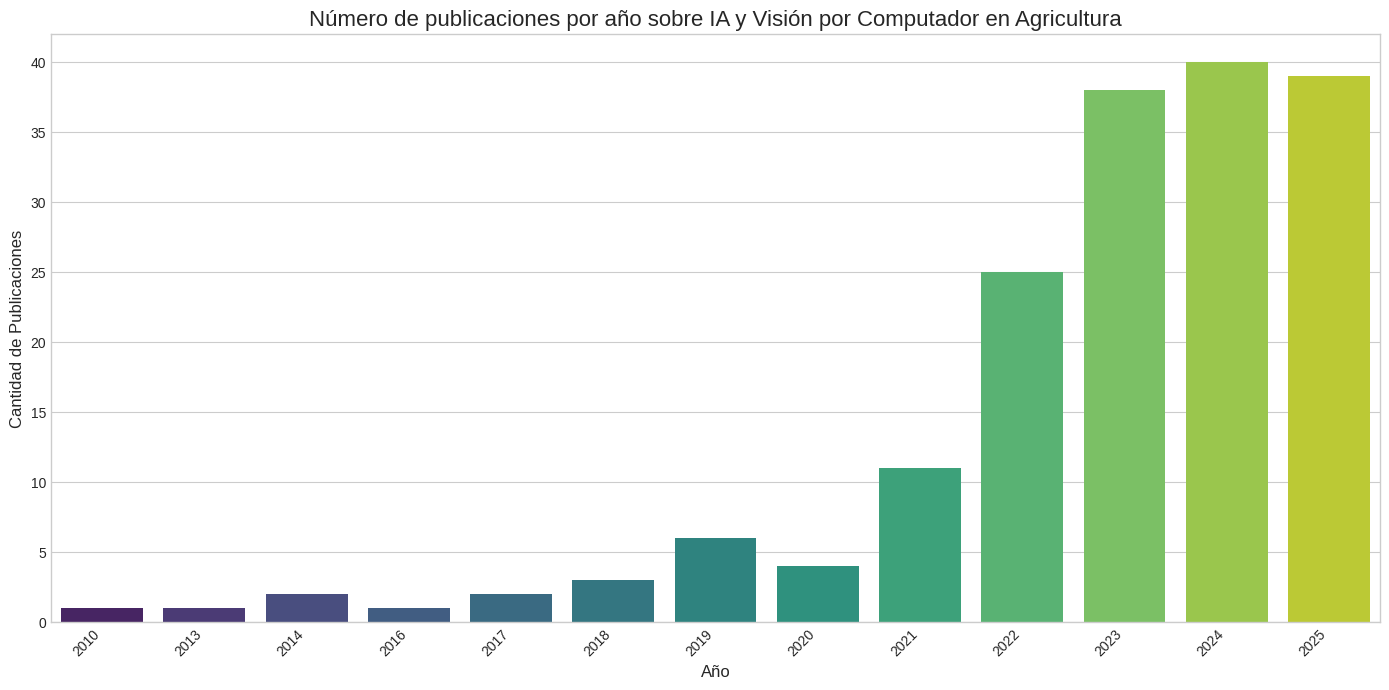

In [ ]:
# Contar publicaciones por año y ordenarlas
publications_per_year = df['year'].value_counts().sort_index()

# Filtrar para mostrar desde el año 2000 para mayor claridad
publications_per_year = publications_per_year[publications_per_year.index >= 2000]

# Visualización
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 7))
sns.barplot(x=publications_per_year.index, y=publications_per_year.values, palette="viridis")
plt.title('Número de publicaciones por año sobre IA y Visión por Computador en Agricultura', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Cantidad de Publicaciones', fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

/tmp/ipykernel_3685393/3052633649.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_authors.values, y=top_authors.index, palette="mako_r", orient='h')


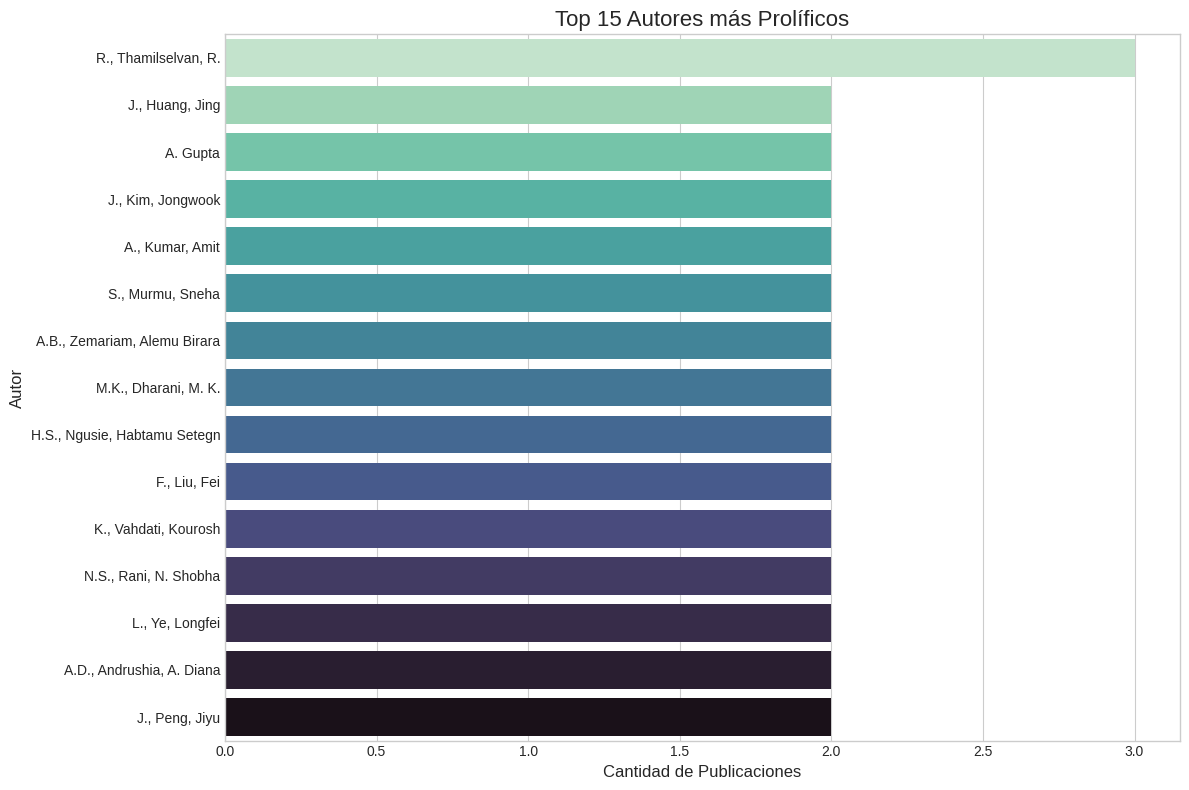

In [ ]:
# Usamos 'explode' para crear una fila por cada autor en la lista 'authors_list'
authors_exploded = df.explode('authors_list')

# Contamos la frecuencia de cada autor y tomamos el top 15
top_authors = authors_exploded['authors_list'].value_counts().nlargest(15)

# Visualización
plt.figure(figsize=(12, 8))
sns.barplot(x=top_authors.values, y=top_authors.index, palette="mako_r", orient='h')
plt.title('Top 15 Autores más Prolíficos', fontsize=16)
plt.xlabel('Cantidad de Publicaciones', fontsize=12)
plt.ylabel('Autor', fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
# Rellenar valores nulos en columnas clave para el análisis
df['authors'].fillna('Desconocido', inplace=True)
df['author_keywords'].fillna('', inplace=True)
df['document_type'].fillna('No especificado', inplace=True)
df['source_title'].fillna('No especificado', inplace=True)


# --- 3. Estructurar Columnas para Análisis ---
# Crear listas a partir de cadenas separadas por ';'
def split_and_clean(text, delimiter=';'):
    if not isinstance(text, str):
        return []
    return [item.strip() for item in text.split(delimiter) if item.strip()]

df['authors_list'] = df['authors'].apply(split_and_clean)
df['keywords_list'] = df['author_keywords'].apply(lambda x: [kw.lower() for kw in split_and_clean(x)])

print("\nPreparación de datos completada. ¡Listos para el EDA!")


Preparación de datos completada. ¡Listos para el EDA!


/tmp/ipykernel_3685393/1145837404.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['authors'].fillna('Desconocido', inplace=True)
/tmp/ipykernel_3685393/1145837404.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)

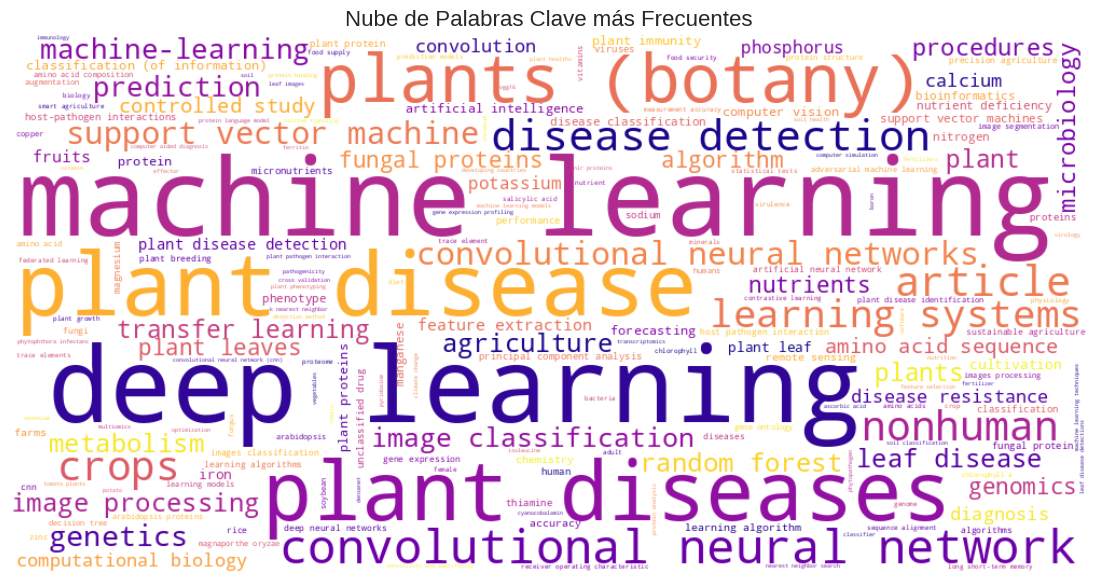

In [ ]:
# Juntar todas las palabras clave en una sola lista
all_keywords = [kw for sublist in df['keywords_list'] for kw in sublist]

# Contar la frecuencia de cada palabra clave
keyword_counts = Counter(all_keywords)

# Generar la nube de palabras



wordcloud = WordCloud(width=1000, height=500, background_color='white', colormap='plasma').generate_from_frequencies(keyword_counts)

# Visualización
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras Clave más Frecuentes', fontsize=16)
plt.show()


/tmp/ipykernel_3685393/2708844536.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_sources.values, y=top_sources.index, palette="rocket_r", orient='h')


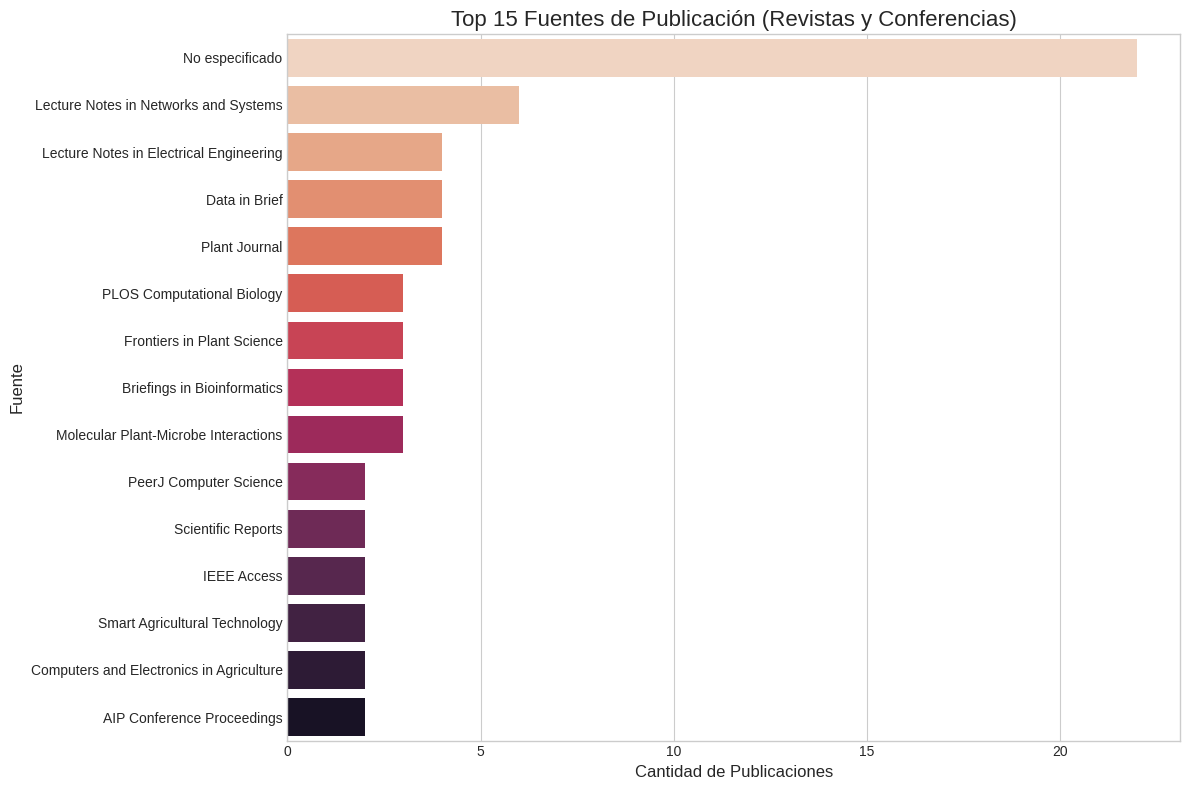

In [ ]:
# Contar publicaciones por fuente y tomar el top 15
top_sources = df['source_title'].value_counts().nlargest(15)

# Visualización
plt.figure(figsize=(12, 8))
sns.barplot(x=top_sources.values, y=top_sources.index, palette="rocket_r", orient='h')
plt.title('Top 15 Fuentes de Publicación (Revistas y Conferencias)', fontsize=16)
plt.xlabel('Cantidad de Publicaciones', fontsize=12)
plt.ylabel('Fuente', fontsize=12)
plt.tight_layout()
plt.show()


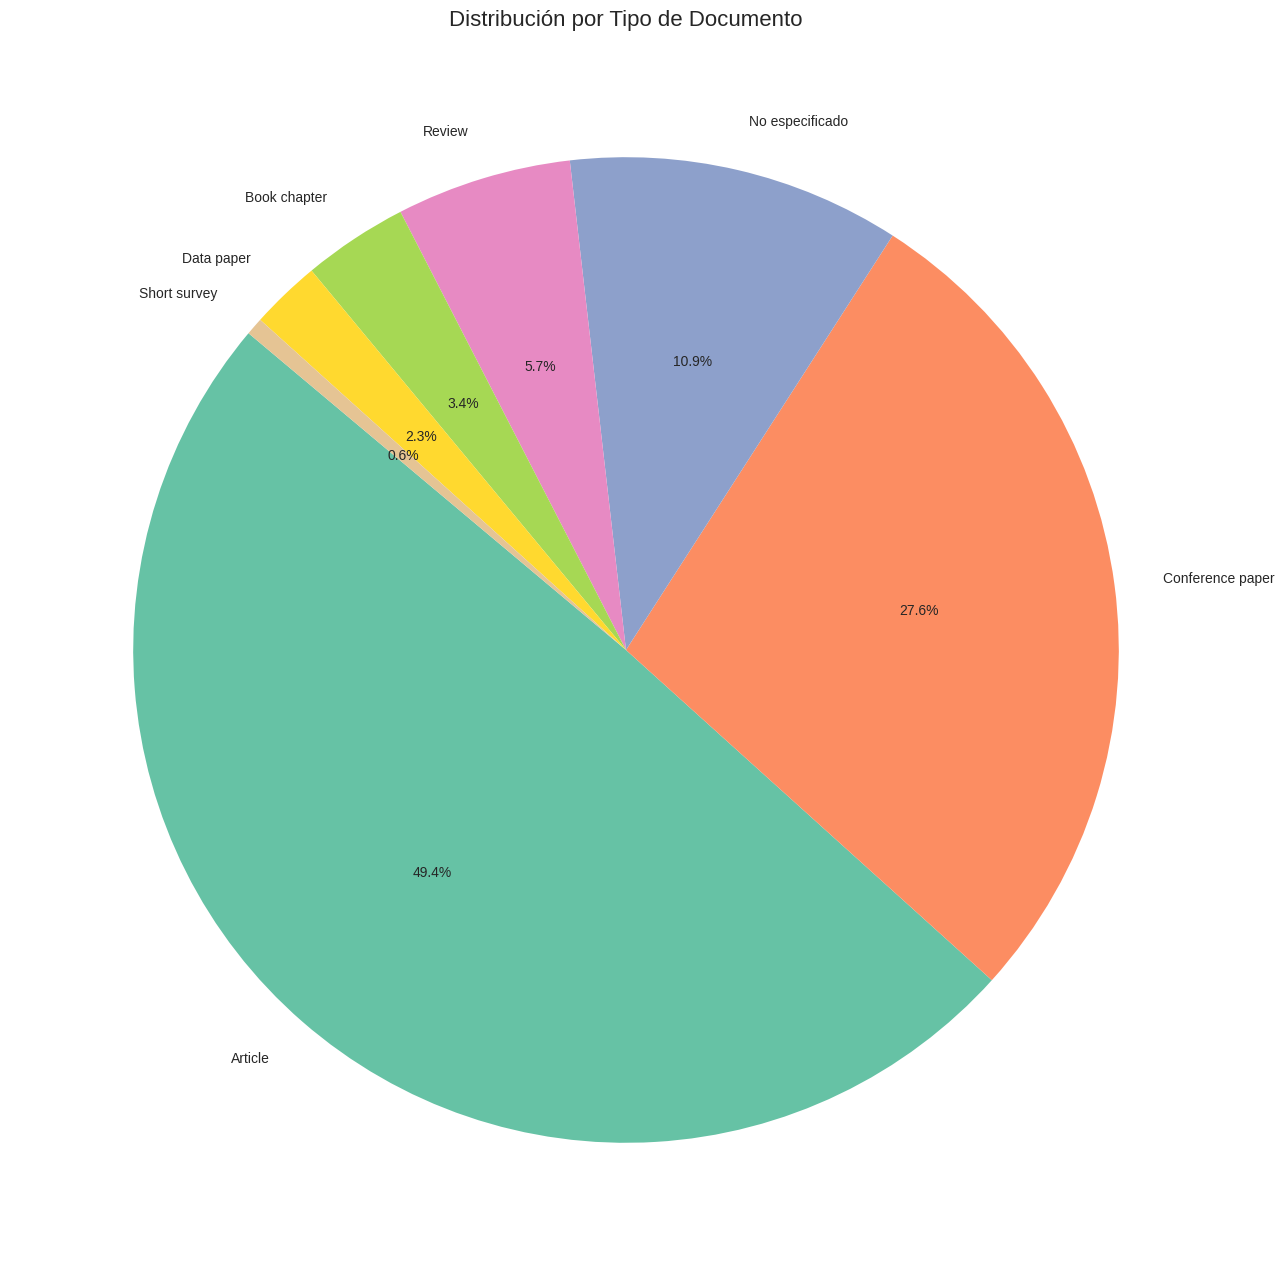

In [ ]:
# Contar la frecuencia de cada tipo de documento
doc_types = df['document_type'].value_counts()

# Visualización
plt.figure(figsize=(24, 16))
plt.pie(doc_types, labels=doc_types.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set2"))
plt.title('Distribución por Tipo de Documento', fontsize=16)
plt.ylabel('') # Ocultar la etiqueta del eje y
plt.show()


In [ ]:
# Lista para almacenar todas las aristas (pares de co-autores)
edge_list = []

# Iterar sobre cada lista de autores en el DataFrame
for authors in df['authors_list']:
    # Solo nos interesan las publicaciones con 2 o más autores
    if len(authors) > 1:
        # Generar todas las combinaciones de 2 autores
        # Usamos sorted() para que el par (Autor A, Autor B) sea igual a (Autor B, Autor A)
        links = combinations(sorted(authors), 2)
        edge_list.extend(links)

# Contar la frecuencia de cada colaboración (el peso de cada arista)
collaboration_counts = Counter(edge_list)

print(f"Se encontraron {len(collaboration_counts)} colaboraciones únicas.")
print("\nTop 10 colaboraciones más fuertes:")
print(collaboration_counts.most_common(10))


Se encontraron 2067 colaboraciones únicas.

Top 10 colaboraciones más fuertes:
[(('F., Liu, Fei', 'F., Zhou, Fei'), 2), (('F., Liu, Fei', 'J., Huang, Jing'), 2), (('F., Liu, Fei', 'J., Peng, Jiyu'), 2), (('F., Liu, Fei', 'L., Ye, Longfei'), 2), (('F., Liu, Fei', 'Y., Liu, Yifan'), 2), (('F., Zhou, Fei', 'J., Huang, Jing'), 2), (('F., Zhou, Fei', 'J., Peng, Jiyu'), 2), (('F., Zhou, Fei', 'L., Ye, Longfei'), 2), (('F., Zhou, Fei', 'Y., Liu, Yifan'), 2), (('J., Huang, Jing', 'J., Peng, Jiyu'), 2)]


In [ ]:
# Crear un grafo vacío
G = nx.Graph()

# Añadir las aristas con su peso (número de colaboraciones)
for (author1, author2), count in collaboration_counts.items():
    G.add_edge(author1, author2, weight=count)

print(f"\nGrafo creado con {G.number_of_nodes()} nodos (autores) y {G.number_of_edges()} aristas (colaboraciones).")



Grafo creado con 824 nodos (autores) y 2067 aristas (colaboraciones).


In [ ]:
# --- Filtrar para mantener solo el núcleo de la red ---
# 1. Calcular el número de publicaciones de cada autor
all_authors = [author for sublist in df['authors_list'] for author in sublist]
author_counts = Counter(all_authors)

# 2. Seleccionar los N autores más prolíficos (ej. top 50)
N_TOP_AUTHORS = 50
top_authors_list = [author for author, count in author_counts.most_common(N_TOP_AUTHORS)]

# 3. Crear un subgrafo que solo contenga a estos autores y las conexiones entre ellos
core_graph = G.subgraph(top_authors_list)

# 4. (Opcional pero recomendado) Mantener solo el componente conectado más grande para una mejor visualización
largest_cc = max(nx.connected_components(core_graph), key=len)
final_graph = core_graph.subgraph(largest_cc)

print(f"\nSubgrafo final para visualización con {final_graph.number_of_nodes()} autores y {final_graph.number_of_edges()} colaboraciones.")



Subgrafo final para visualización con 10 autores y 45 colaboraciones.


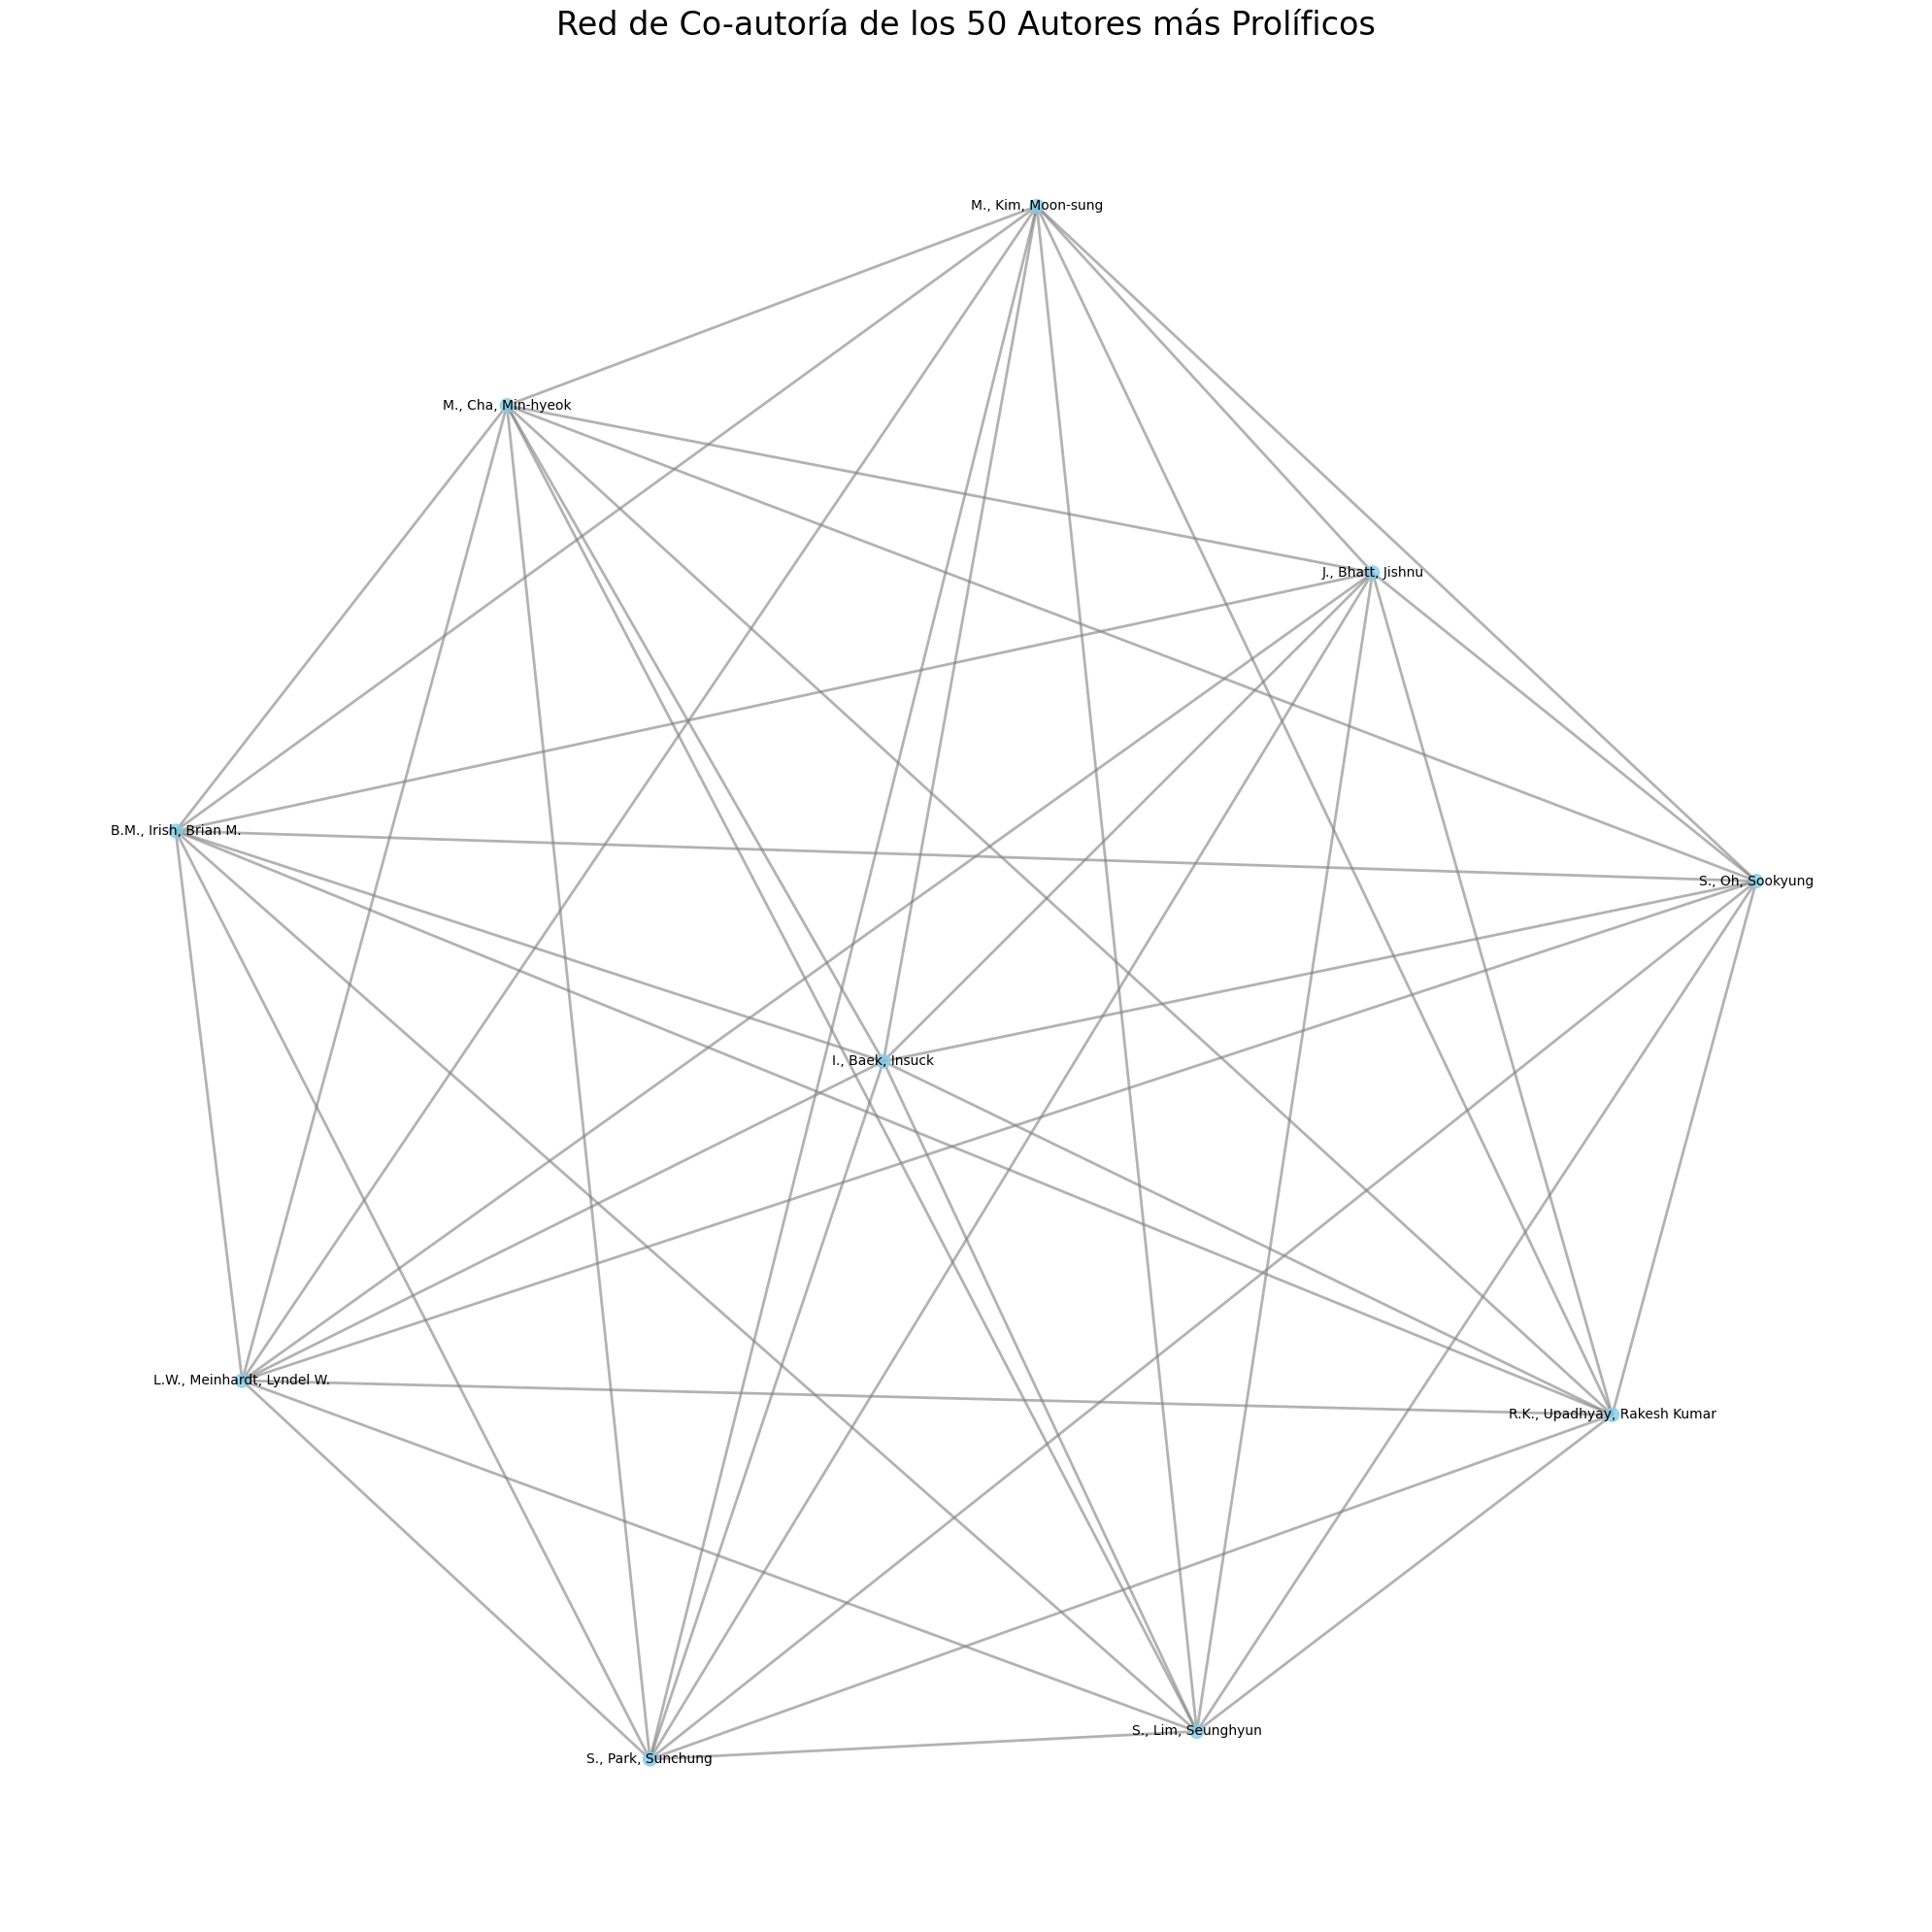

In [ ]:
plt.style.use('default')
plt.figure(figsize=(20, 20))

# --- Posicionamiento de los nodos ---
# El layout "spring" simula una repulsión entre nodos y una atracción por las aristas
pos = nx.spring_layout(final_graph, k=0.6, iterations=50, seed=42)

# --- Dibujar los nodos ---
# El tamaño del nodo será proporcional a su número de publicaciones
node_sizes = [author_counts[node] * 100 for node in final_graph.nodes()]
nx.draw_networkx_nodes(final_graph, pos, node_size=node_sizes, node_color='skyblue', alpha=0.8)

# --- Dibujar las aristas ---
# El grosor de la arista será proporcional al número de colaboraciones
edge_weights = [final_graph[u][v]['weight'] * 2 for u, v in final_graph.edges()]
nx.draw_networkx_edges(final_graph, pos, width=edge_weights, edge_color='gray', alpha=0.6)

# --- Dibujar las etiquetas (nombres de los autores) ---
nx.draw_networkx_labels(final_graph, pos, font_size=10, font_family='sans-serif')

# --- Títulos y configuración del gráfico ---
plt.title('Red de Co-autoría de los 50 Autores más Prolíficos', fontsize=24)
plt.axis('off') # Ocultar los ejes
plt.tight_layout()
plt.show()


In [ ]:
# Seleccionar y combinar las columnas de texto. Rellenar nulos con ''
df['title'] = df['title'].fillna('')
df['abstract'] = df['abstract'].fillna('')
df['documents'] = df['title'] + '. ' + df['abstract']

print(f"Dataset preparado con {len(df)} documentos únicos para el análisis LDA.")
print("\nEjemplo de documento combinado:")
print(df['documents'].iloc[1])

Dataset preparado con 174 documentos únicos para el análisis LDA.

Ejemplo de documento combinado:
Integrated phenotypic analysis, predictive modeling, and identification of novel trait-associated loci in a diverse Theobroma cacao collection. Background: Cacao (Theobroma cacao L.) breeding and improvement rely on understanding germplasm diversity and trait architecture. This study characterized a cacao collection (173 accessions) evaluated in Puerto Rico, examining phenotypic diversity, trait interrelationships, and performing comparative analyses with published Trinidad and Colombia datasets. We also developed machine learning (ML) models for yield prediction and identified yield-associated SNP markers. Results: The cacao collection showed significant phenotypic variation and strong intra-collection trait correlations. Comparative analyses revealed conserved trait responses across environments, notably linking susceptibility to black pod rot in Puerto Rico with Witches' Broom Disease 

In [ ]:
nltk.download('wordnet')
# --- 2. Pre-procesamiento de Texto ---

# Inicializar lemmatizer y stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Stopwords organizadas según las facetas del tesauro del proyecto
custom_stopwords = {
    # Faceta TECH: Tecnología
    'tech_terms': {
        # Términos generales de IA y ML
        'artificial', 'intelligence', 'ai', 'machine', 'learning',
        'deep', 'neural', 'network', 'cnn', 'algorithm', 'model',
        # Términos de visión por computador
        'image', 'images', 'processing', 'recognition', 'detection',
        'classification', 'segmentation', 'computer', 'vision',
        # Términos de análisis espectral
        # 'spectral', 'analysis', 'nir', 'near', 'infrared', 'hyperspectral',
        # 'imaging', 'sensor', 'sensors', 'measurement', 'measurements'
    },

    # Faceta PLANT_HEALTH: Salud de la Planta
    'plant_health_terms': {
        # Términos de enfermedades y patógenos
        'disease', 'diseases', 'pathogen', 'pathogens', 'infection',
        'infections', 'pest', 'pests', 'symptom', 'symptoms',
        # Términos de estrés y deficiencias
        'stress', 'deficiency', 'deficiencies', 'disorder', 'disorders',
        'damage', 'health', 'condition', 'conditions',
        # Términos generales de plantas
        'plant', 'plants', 'leaf', 'leaves', 'foliar', 'tissue',
        'root', 'stem', 'growth', 'development'
    },

    # Faceta PREDICTION: Predicción
    'prediction_terms': {
        # Términos de predicción y estimación
        'predict', 'prediction', 'forecast', 'forecasting', 'estimate',
        'estimation', 'assess', 'assessment', 'evaluate', 'evaluation',
        # Términos de monitoreo
        'monitor', 'monitoring', 'track', 'tracking', 'detect',
        'detection', 'identify', 'identification', 'analyze', 'analysis',
        # Términos de modelado
        'model', 'modeling', 'simulate', 'simulation', 'calculate',
        'calculation', 'measure', 'measurement'
    },

    # Faceta QUALITY: Calidad Nutricional
    'quality_terms': {
        # Términos de nutrición
        'nutritional', 'nutrition', 'nutrient', 'nutrients',
        'macronutrient', 'micronutrient', 'vitamin', 'mineral',
        # Términos de calidad
        'quality', 'property', 'properties', 'characteristic',
        'characteristics', 'parameter', 'parameters',
        # Términos de composición
        'content', 'composition', 'component', 'components',
        'level', 'levels', 'concentration', 'concentrations'
    },

    # Términos metodológicos generales
    # 'research_terms': {
    #     'study', 'research', 'paper', 'article', 'method', 'approach',
    #     'technique', 'result', 'analysis', 'using', 'based', 'propose',
    #     'investigate', 'demonstrate', 'perform', 'conduct', 'implement',
    #     'evaluate', 'validate', 'verify', 'test'
    # }
}

# Combinar todas las stopwords personalizadas en un solo conjunto
all_custom_stopwords = set()
for facet_words in custom_stopwords.values():
    all_custom_stopwords.update(facet_words)

# Actualizar el conjunto de stopwords con las personalizadas
stop_words.update(all_custom_stopwords)

def preprocess_text(text):
    # 1. Convertir a minúsculas
    text = text.lower()
    # 2. Eliminar caracteres no alfabéticos (puntuación, números, etc.)
    text = re.sub(r'[^a-z\s]', '', text)
    # 3. Tokenizar (dividir el texto en palabras)
    tokens = text.split()
    # 4. Lemmatizar y eliminar stopwords y palabras cortas
    lemmatized_tokens = [
        lemmatizer.lemmatize(token) for token in tokens 
        if token not in stop_words and len(token) > 2
    ]
    return lemmatized_tokens

# Aplicar la función de pre-procesamiento a todos los documentos
processed_docs = df['documents'].map(preprocess_text)

print("\nEjemplo de documento procesado (tokenizado y lemmatizado):")
print(processed_docs.iloc[1])

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/aalejoz25/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



Ejemplo de documento procesado (tokenizado y lemmatizado):
['integrated', 'phenotypic', 'predictive', 'novel', 'traitassociated', 'locus', 'diverse', 'theobroma', 'cacao', 'collection', 'background', 'cacao', 'theobroma', 'cacao', 'breeding', 'improvement', 'rely', 'understanding', 'germplasm', 'diversity', 'trait', 'architecture', 'study', 'characterized', 'cacao', 'collection', 'accession', 'evaluated', 'puerto', 'rico', 'examining', 'phenotypic', 'diversity', 'trait', 'interrelationship', 'performing', 'comparative', 'analysis', 'published', 'trinidad', 'colombia', 'datasets', 'also', 'developed', 'model', 'yield', 'identified', 'yieldassociated', 'snp', 'marker', 'result', 'cacao', 'collection', 'showed', 'significant', 'phenotypic', 'variation', 'strong', 'intracollection', 'trait', 'correlation', 'comparative', 'analysis', 'revealed', 'conserved', 'trait', 'response', 'across', 'environment', 'notably', 'linking', 'susceptibility', 'black', 'pod', 'rot', 'puerto', 'rico', 'witch

In [ ]:
# --- 3. Crear Diccionario y Corpus ---

# Crear un diccionario a partir de los documentos procesados
# El diccionario mapea cada palabra a un ID único.
dictionary = Dictionary(processed_docs)

# Filtrar palabras extremas:
# - no_below: ignora palabras que aparecen en menos de 5 documentos.
# - no_above: ignora palabras que aparecen en más del 50% de los documentos.
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Crear el corpus (Bolsa de Palabras)
# Convierte cada documento en una lista de tuplas (word_id, frequency).
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

print(f"\nDiccionario creado con {len(dictionary)} palabras únicas.")
print("Ejemplo de un documento en formato BoW (ID de palabra, frecuencia):")
print(corpus[1][:10]) # Muestra los primeros 10 pares



Diccionario creado con 825 palabras únicas.
Ejemplo de un documento en formato BoW (ID de palabra, frecuencia):
[(14, 1), (19, 1), (20, 1), (33, 1), (35, 1), (46, 1), (51, 2), (52, 1), (53, 2), (57, 1)]


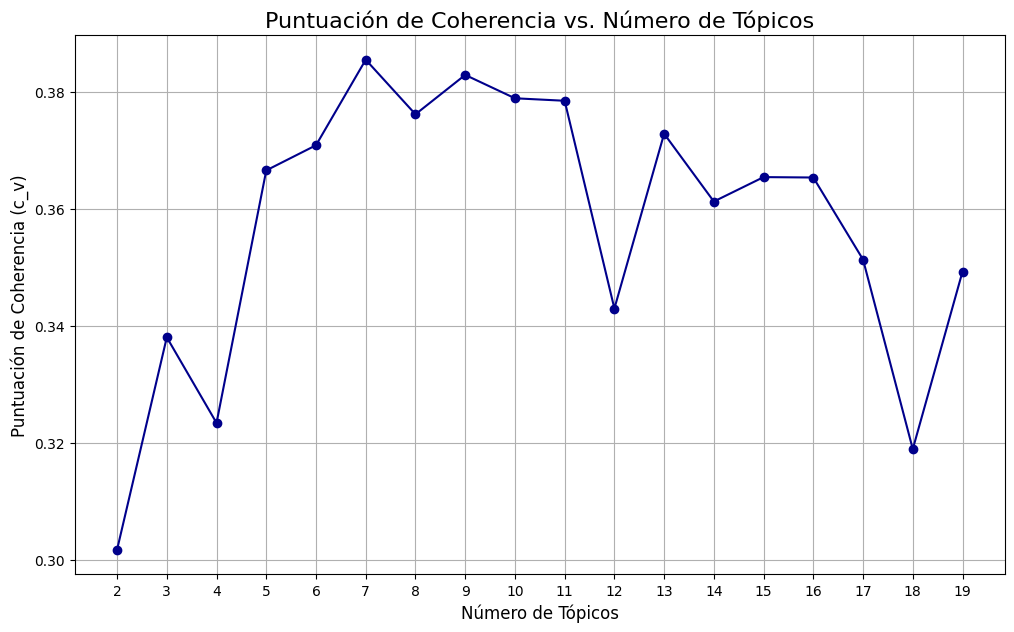


El número óptimo de tópicos es: 7 (con una coherencia de 0.3856)

Modelo LDA entrenado con los mejores hiperparámetros.

Tópicos descubiertos (palabras clave por tópico):
Tópico: 1 
Palabras: 0.060*"cassava" + 0.022*"blight" + 0.017*"potato" + 0.015*"rice" + 0.015*"early" + 0.013*"feature" + 0.013*"used" + 0.013*"different" + 0.011*"time" + 0.011*"food"

Tópico: 2 
Palabras: 0.050*"tomato" + 0.022*"fruit" + 0.019*"grape" + 0.019*"production" + 0.017*"crop" + 0.016*"farmer" + 0.016*"loss" + 0.014*"feature" + 0.013*"used" + 0.012*"different"

Tópico: 3 
Palabras: 0.053*"protein" + 0.033*"effector" + 0.022*"sequence" + 0.017*"gene" + 0.015*"interaction" + 0.012*"approach" + 0.011*"study" + 0.010*"resistance" + 0.010*"acid" + 0.009*"feature"

Tópico: 4 
Palabras: 0.034*"yolov" + 0.024*"increase" + 0.021*"map" + 0.014*"new" + 0.013*"evolutionary" + 0.012*"average" + 0.012*"high" + 0.012*"performance" + 0.012*"study" + 0.011*"result"

Tópico: 5 
Palabras: 0.024*"crop" + 0.020*"soil" + 0.012

In [ ]:
# --- 4. Búsqueda de Hiperparámetros: Encontrar el número óptimo de tópicos ---
from gensim.models import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Calcula la puntuación de coherencia para varios números de tópicos.
    """
    coherence_values = []
    model_list = []
    for num_topics_iter in range(start, limit, step):
        model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics_iter,
                         random_state=100,
                         update_every=1,
                         chunksize=100,
                         passes=10,
                         alpha='auto',
                         per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        
        # Calcular la coherencia UNA SOLA VEZ
        coherence_score = coherencemodel.get_coherence()
        
        # Usar el valor guardado
        coherence_values.append(coherence_score)
        # print(f"Evaluado para {num_topics_iter} tópicos con coherencia: {coherence_score:.4f}")

    return model_list, coherence_values

# --- Ejecutar la búsqueda y visualizar los resultados ---
# Definir el rango de tópicos a probar
start_topics = 2
limit_topics = 20 # Puedes ajustar este límite si lo deseas
step_topics = 1

model_list, coherence_values = compute_coherence_values(
    dictionary=dictionary,
    corpus=corpus,
    texts=processed_docs,
    start=start_topics,
    limit=limit_topics,
    step=step_topics
)

# --- Visualizar los resultados de la coherencia ---
x = range(start_topics, limit_topics, step_topics)
plt.figure(figsize=(12, 7))
plt.plot(x, coherence_values, marker='o', color='darkblue')
plt.title('Puntuación de Coherencia vs. Número de Tópicos', fontsize=16)
plt.xlabel("Número de Tópicos", fontsize=12)
plt.ylabel("Puntuación de Coherencia (c_v)", fontsize=12)
plt.xticks(x)
plt.grid(True)
plt.show()

# --- Seleccionar el mejor modelo y mostrar los resultados ---
# Encontrar el número óptimo de tópicos (el que tiene la mayor coherencia)
optimal_idx = coherence_values.index(max(coherence_values))
optimal_num_topics = x[optimal_idx]

# Seleccionar el mejor modelo de la lista
lda_model = model_list[optimal_idx]

# Actualizar la variable num_topics para que el resto del notebook la use
num_topics = optimal_num_topics

print(f"\nEl número óptimo de tópicos es: {optimal_num_topics} (con una coherencia de {max(coherence_values):.4f})")
print("\nModelo LDA entrenado con los mejores hiperparámetros.")
print("\nTópicos descubiertos (palabras clave por tópico):")
for idx, topic in lda_model.print_topics(-1):
    print(f"Tópico: {idx+1} \nPalabras: {topic}\n")

In [ ]:
# --- 5. Visualización de los Tópicos ---

# Habilitar el formateador de pyLDAvis para notebooks (si usas uno)
pyLDAvis.enable_notebook()

# Preparar los datos para la visualización
# NOTA: El cálculo puede tardar unos minutos en datasets grandes.
vis_data = gensimvis.prepare(lda_model, corpus, dictionary, mds='mmds')

# Guardar la visualización en un archivo HTML
output_filepath = './LDA_resultados.html'
pyLDAvis.save_html(vis_data, output_filepath)

print(f"\n¡Visualización LDA guardada en '{output_filepath}'!")
print("Abre este archivo en tu navegador para explorar los tópicos de forma interactiva.")

# Mostrar la visualización directamente (si estás en un Jupyter Notebook/Lab)
vis_data



¡Visualización LDA guardada en './LDA_resultados.html'!
Abre este archivo en tu navegador para explorar los tópicos de forma interactiva.


/home/aalejoz25/.pyenv/versions/3.10.2/lib/python3.10/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.010110 -0.002241       1        1  31.629380
2     -0.262992  0.073574       2        1  20.788623
6      0.110780  0.153125       3        1  14.381557
0      0.247984 -0.023013       4        1  11.347407
1      0.120459 -0.212964       5        1  10.903136
5     -0.155460 -0.179073       6        1   7.852698
3     -0.070881  0.190591       7        1   3.097199, topic_info=          Term        Freq       Total Category  logprob  loglift
209    cassava   97.000000   97.000000  Default  30.0000  30.0000
118    protein  175.000000  175.000000  Default  29.0000  29.0000
793     tomato   78.000000   78.000000  Default  28.0000  28.0000
446   effector   97.000000   97.000000  Default  27.0000  27.0000
284   sequence   65.000000   65.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
51       model    3.543984  121.285651   Topic7  -4.8190  -0.0582
80     various    3.344466   71.829388   Topic7  -4.8770   0.4077
118    protein    3.588291  175.207458   Topic7  -4.8066  -0.4136
197   training    3.031398   33.445449   Topic7  -4.9753   1.0738
184  precision    2.993817   45.418729   Topic7  -4.9877   0.7553

[413 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
457       3  0.854750      access
1         2  0.966490        acid
204       3  0.661016  additional
204       6  0.264407  additional
458       1  0.264867      affect
...     ...       ...         ...
145       7  0.018866       yield
442       4  0.329165     yielded
442       6  0.658331     yielded
609       5  0.059857       yolov
609       7  0.897860       yolov

[892 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 7, 1, 2, 6, 4])

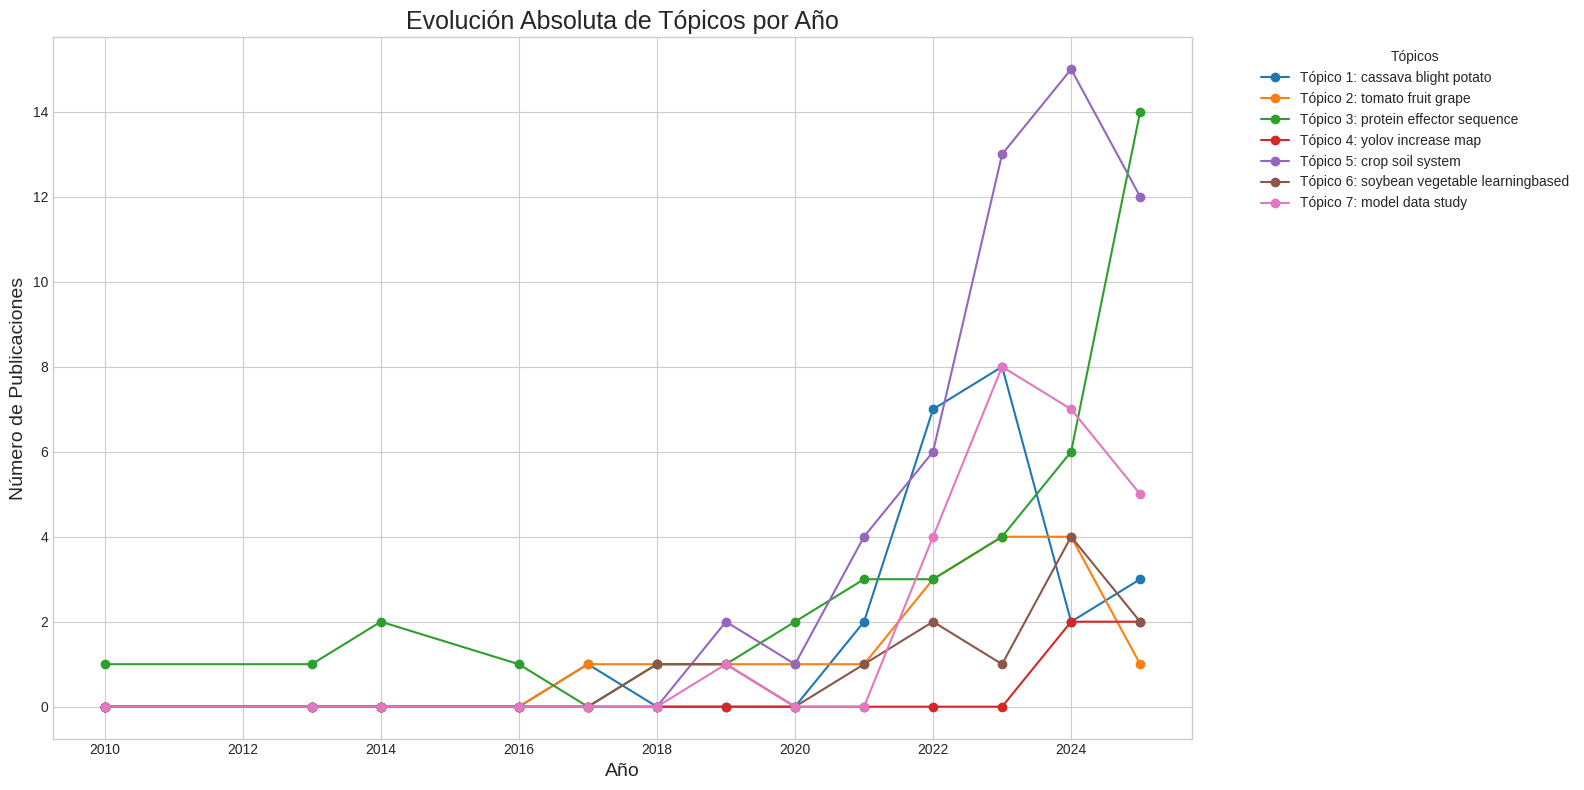

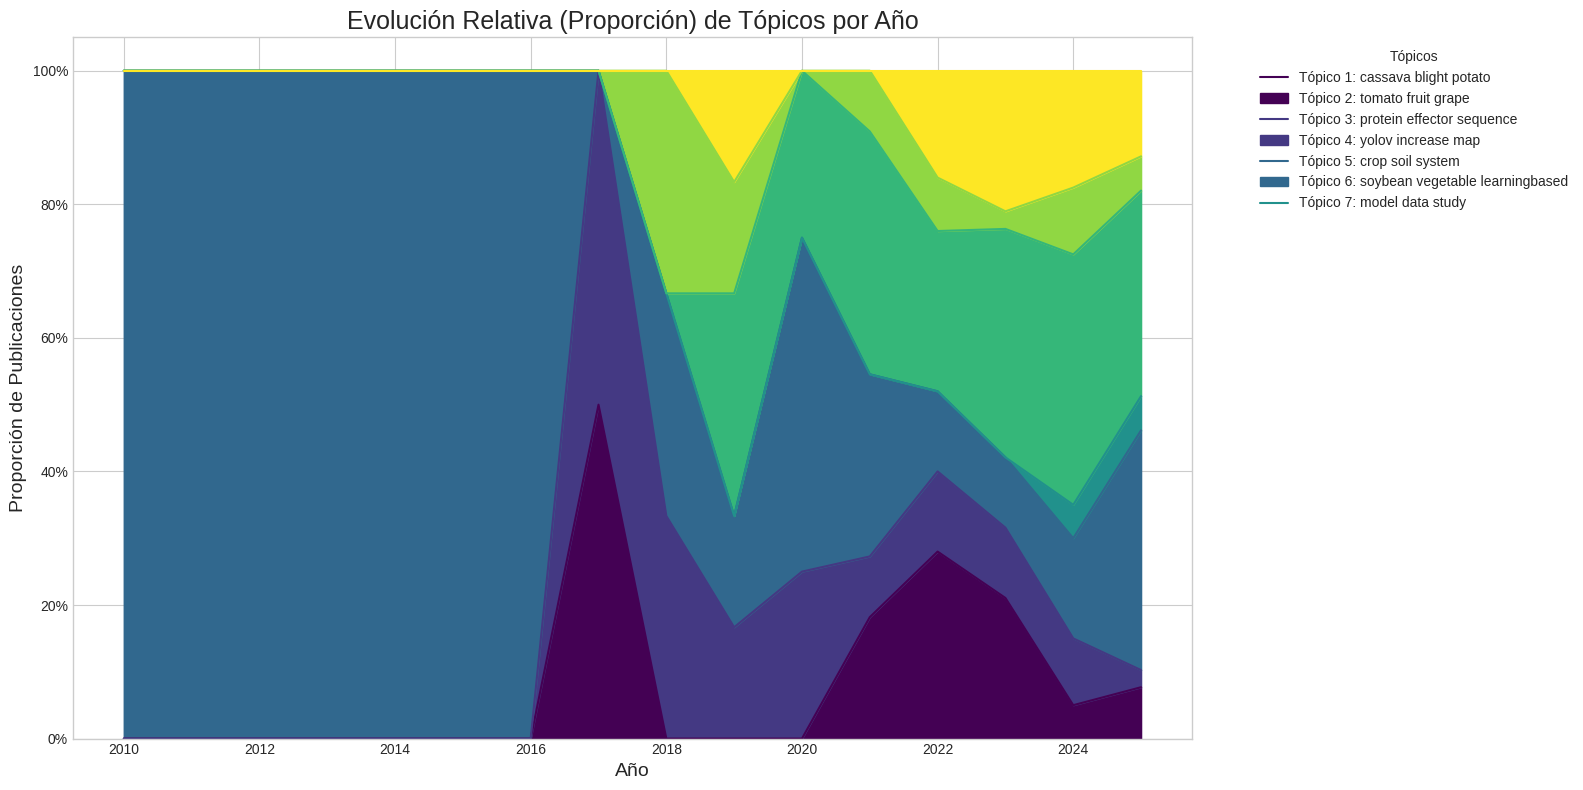

In [ ]:
# --- 3. Asignar Tópico Dominante a cada Documento ---
def get_dominant_topic(bow):
    # Obtener la distribución de tópicos para un documento
    topic_distribution = lda_model.get_document_topics(bow, minimum_probability=0.0)
    # Ordenar por probabilidad y obtener el tópico con la más alta
    dominant_topic = sorted(topic_distribution, key=lambda x: x[1], reverse=True)[0]
    return dominant_topic[0]

# Crear una nueva columna en el DataFrame con el tópico dominante
# Asegurarse de que los índices coincidan después de haber eliminado filas nulas
df['dominant_topic'] = [get_dominant_topic(corpus[i]) for i in range(len(corpus))]

# --- 4. Agrupar por Año y Tópico ---
# Filtrar por un rango de años para una mejor visualización (ej. desde el 2010)
df_filtered = df[df['year'] >= 2010]

# Agrupar por año y tópico dominante, y contar el número de documentos
topic_counts_per_year = df_filtered.groupby(['year', 'dominant_topic']).size().unstack(fill_value=0)

# --- 5. Visualizar la Evolución de los Tópicos ---

# Gráfico 1: Evolución de la popularidad absoluta (número de publicaciones)
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16, 8))
topic_counts_per_year.plot(ax=ax, marker='o', linestyle='-')

# Crear etiquetas de leyenda más descriptivas
topic_keywords = [" ".join([word for word, _ in lda_model.show_topic(i, topn=3)]) for i in range(num_topics)]
legend_labels = [f'Tópico {i+1}: {topic_keywords[i]}' for i in range(num_topics)]

ax.set_title('Evolución Absoluta de Tópicos por Año', fontsize=18)
ax.set_xlabel('Año', fontsize=14)
ax.set_ylabel('Número de Publicaciones', fontsize=14)
ax.legend(legend_labels, title='Tópicos', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Gráfico 2: Evolución de la popularidad relativa (proporción de publicaciones)
# Normalizar los datos para que cada fila sume 1 (100%)
topic_proportions = topic_counts_per_year.div(topic_counts_per_year.sum(axis=1), axis=0)

fig, ax = plt.subplots(figsize=(16, 8))
topic_proportions.plot(kind='area', stacked=True, ax=ax, colormap='viridis')

ax.set_title('Evolución Relativa (Proporción) de Tópicos por Año', fontsize=18)
ax.set_xlabel('Año', fontsize=14)
ax.set_ylabel('Proporción de Publicaciones', fontsize=14)
ax.legend(legend_labels, title='Tópicos', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format)) # Formatear eje Y como porcentaje
plt.tight_layout()
plt.show()

Datos listos para la creación de la red de co-ocurrencia de palabras clave.

Se encontraron 48907 pares de co-ocurrencia únicos.

Top 10 co-ocurrencias más fuertes:
[(('plant disease', 'plant diseases'), 34), (('convolutional neural network', 'convolutional neural networks'), 32), (('phosphorus', 'potassium'), 29), (('article', 'nonhuman'), 24), (('magnesium', 'manganese'), 24), (('plant disease', 'plants (botany)'), 22), (('genetics', 'plant diseases'), 21), (('nitrogen', 'phosphorus'), 20), (('nitrogen', 'potassium'), 20), (('nonhuman', 'plant disease'), 20)]

Grafo final para visualización con 40 nodos y 538 aristas.


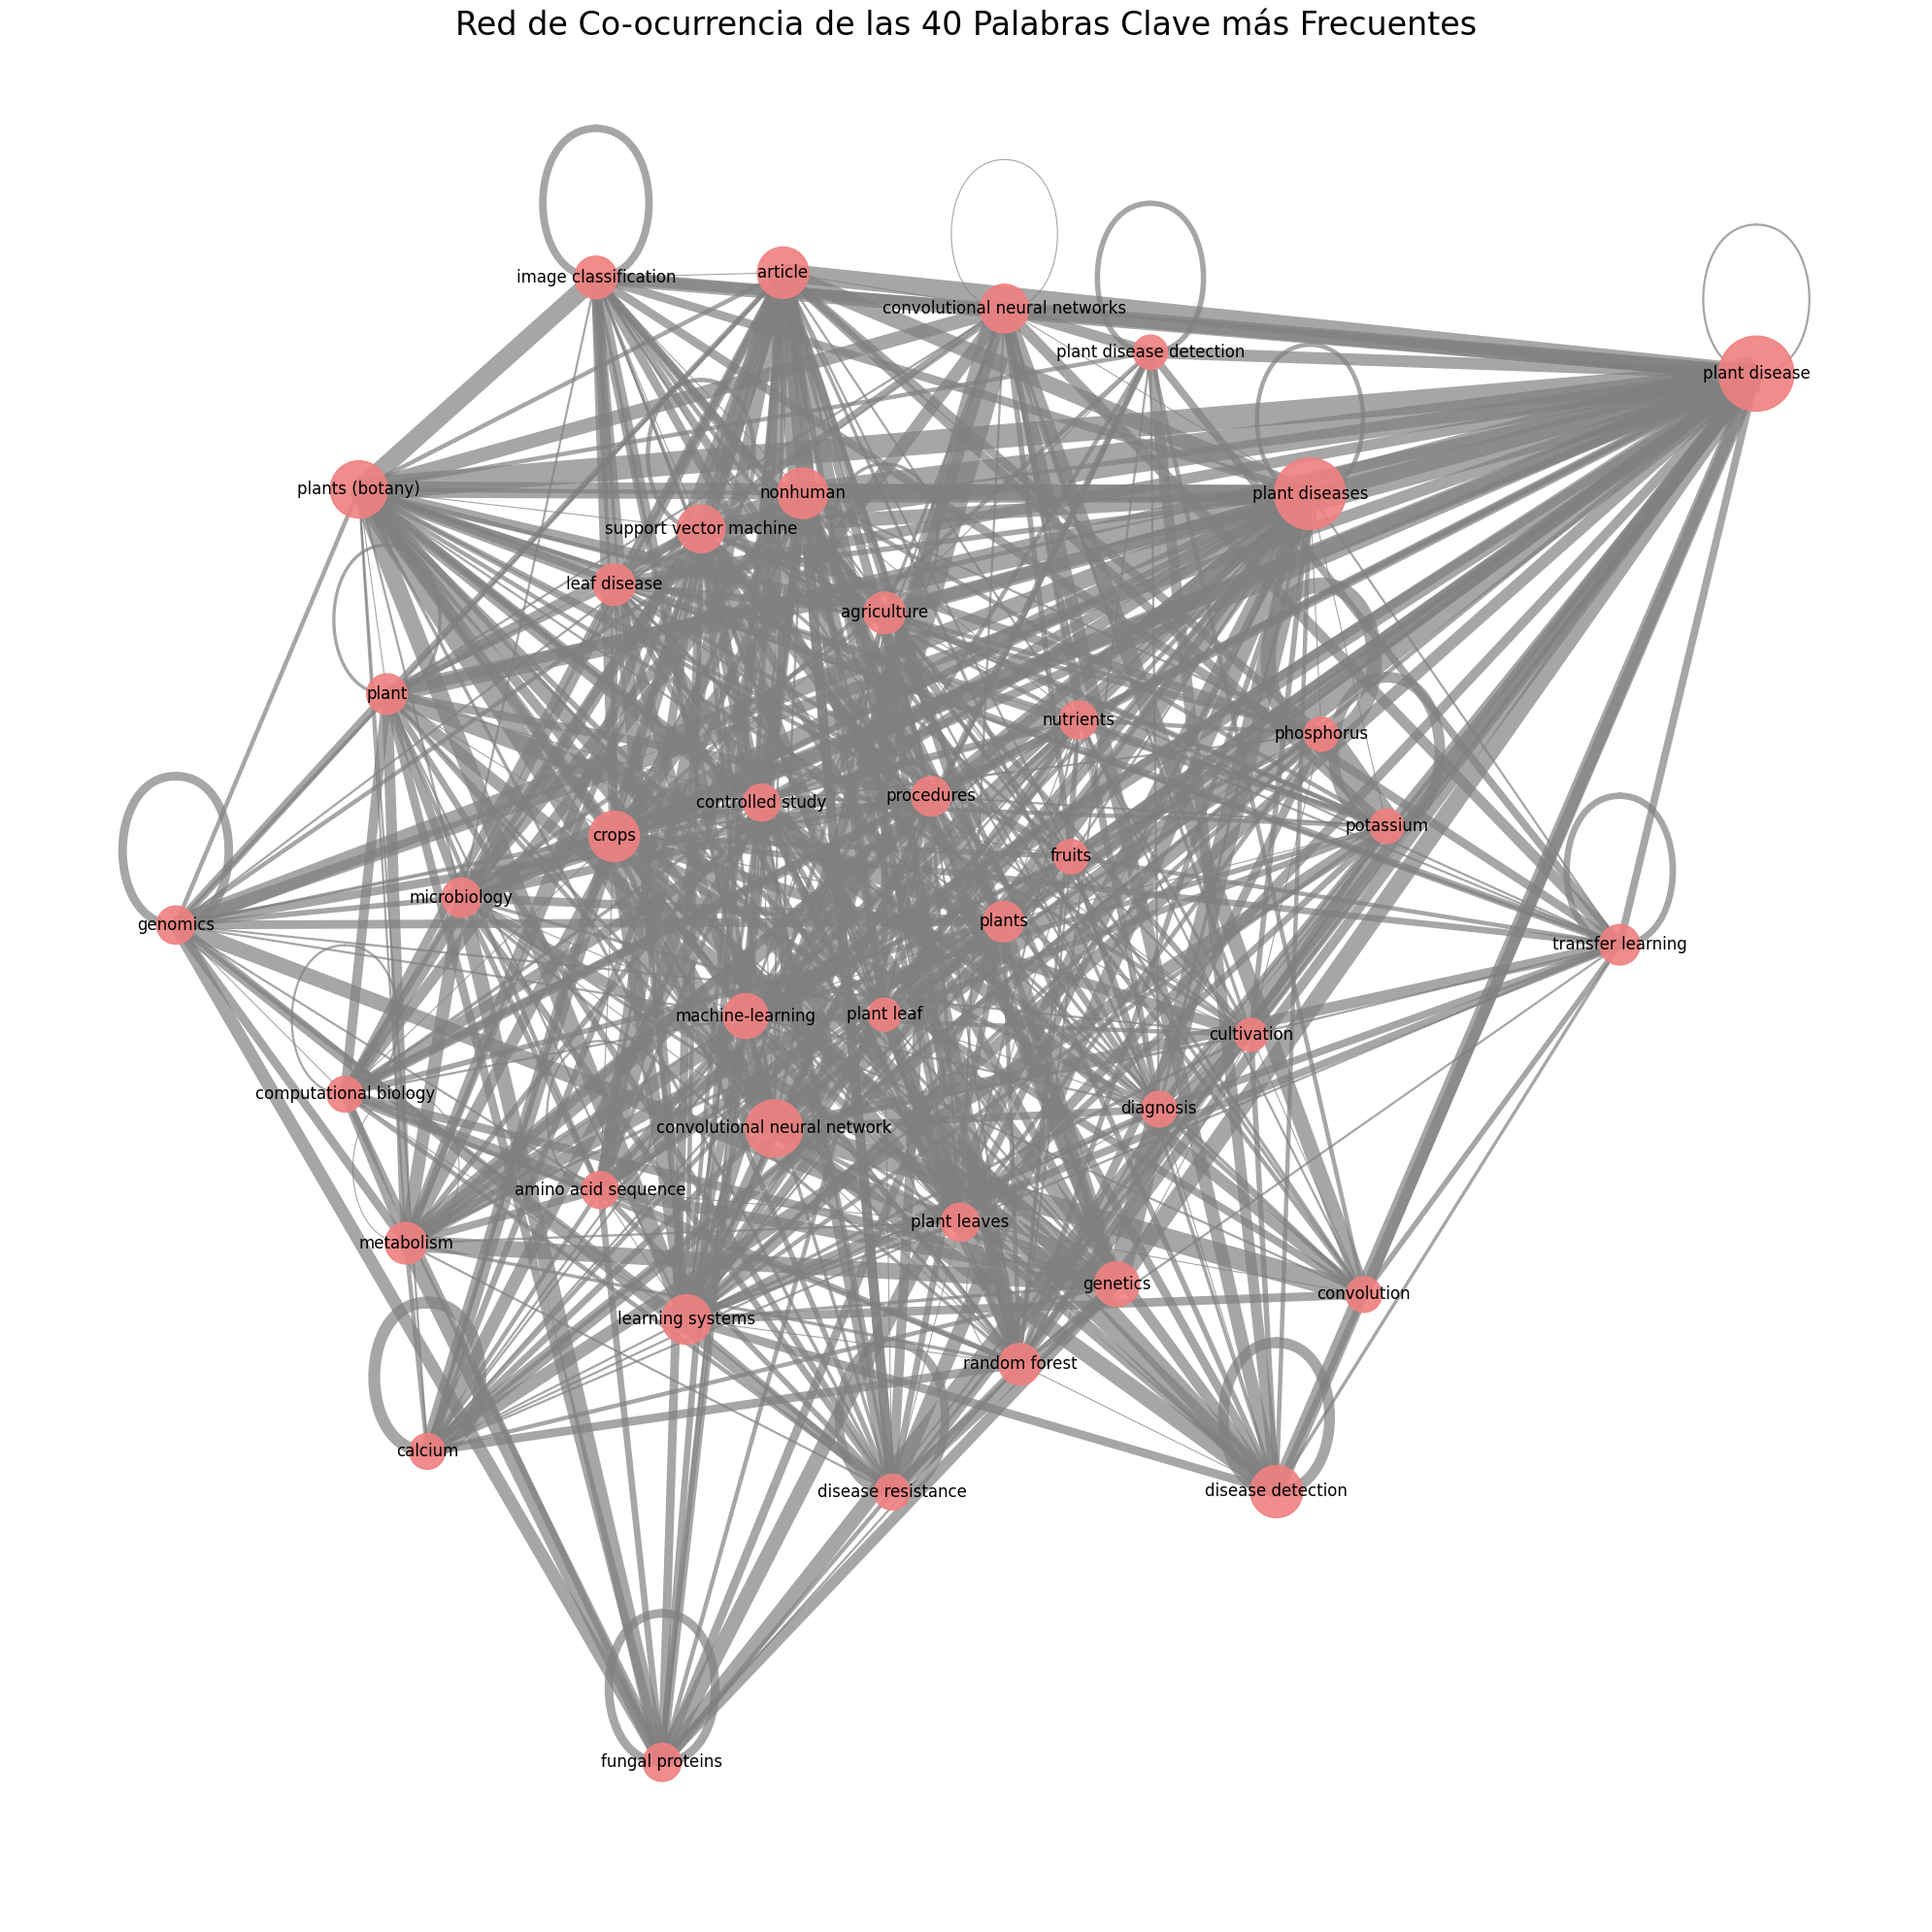

In [ ]:
# --- 2. Procesamiento de Palabras Clave ---
def split_and_clean(text, delimiter=';'):
    if not isinstance(text, str):
        return []
    # Limpiamos, convertimos a minúsculas y eliminamos palabras clave genéricas
    keywords = [item.strip().lower() for item in text.split(delimiter) if item.strip()]
    # Filtramos palabras clave muy genéricas que no aportan valor a la red
    # Palabras clave genéricas y poco informativas para este dominio
    generic_kws = {
        'artificial intelligence', 'ai', 'machine learning', 'deep learning', 'neural network',
        'computer vision', 'image processing', 'classification', 'detection', 'segmentation',
        'algorithm', 'model', 'cnn', 'review', 'survey', 'system', 'approach', 'method',
        'performance', 'accuracy', 'prediction', 'dataset', 'feature extraction', 'training',
        'validation', 'application', 'applications'
    }
    return [kw for kw in keywords if kw not in generic_kws]

df['keywords_list'] = df['author_keywords'].apply(split_and_clean)

print("Datos listos para la creación de la red de co-ocurrencia de palabras clave.")

# --- 3. Generación de Pares de Co-ocurrencia ---
# Lista para almacenar todos los pares de palabras clave que co-ocurren
co_occurrence_pairs = []

for keywords in df['keywords_list']:
    # Solo nos interesan publicaciones con 2 o más palabras clave
    if len(keywords) > 1:
        # Generar todas las combinaciones de 2 palabras clave
        # Usamos sorted() para que el par (A, B) sea igual a (B, A)
        links = combinations(sorted(keywords), 2)
        co_occurrence_pairs.extend(links)

# Contar la frecuencia de cada par (el peso de cada arista)
pair_counts = Counter(co_occurrence_pairs)

print(f"\nSe encontraron {len(pair_counts)} pares de co-ocurrencia únicos.")
print("\nTop 10 co-ocurrencias más fuertes:")
print(pair_counts.most_common(10))

# --- 4. Filtrado y Construcción del Grafo ---
# Contar la frecuencia de cada palabra clave individualmente
all_keywords = [kw for sublist in df['keywords_list'] for kw in sublist]
keyword_counts = Counter(all_keywords)

# Seleccionar las N palabras clave más frecuentes (ej. top 40)
N_TOP_KEYWORDS = 40
top_keywords_list = [kw for kw, count in keyword_counts.most_common(N_TOP_KEYWORDS)]

# Crear el grafo
G = nx.Graph()

# Añadir nodos y aristas ponderadas para las palabras clave del top
for (kw1, kw2), weight in pair_counts.items():
    if kw1 in top_keywords_list and kw2 in top_keywords_list:
        G.add_node(kw1, size=keyword_counts[kw1])
        G.add_node(kw2, size=keyword_counts[kw2])
        G.add_edge(kw1, kw2, weight=weight)

print(f"\nGrafo final para visualización con {G.number_of_nodes()} nodos y {G.number_of_edges()} aristas.")

# --- 5. Visualización de la Red ---
plt.style.use('default')
plt.figure(figsize=(20, 20))

# Layout para posicionar los nodos
pos = nx.kamada_kawai_layout(G)

# Tamaños de los nodos proporcionales a su frecuencia
node_sizes = [data['size'] * 50 for node, data in G.nodes(data=True)]

# Grosor de las aristas proporcional a su peso (frecuencia de co-ocurrencia)
edge_widths = [d['weight'] * 0.8 for (u, v, d) in G.edges(data=True)]

# Dibujar la red
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lightcoral', alpha=0.9)
nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color='grey', alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

plt.title('Red de Co-ocurrencia de las 40 Palabras Clave más Frecuentes', fontsize=24)
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# --- 3. Asignar Tópico Dominante a cada Documento ---
def get_dominant_topic_for_doc(doc_bow):
    # Obtener la distribución de tópicos para un documento
    topic_distribution = lda_model.get_document_topics(doc_bow, minimum_probability=0.0)
    # Encontrar el tópico con la probabilidad más alta
    dominant_topic = max(topic_distribution, key=lambda x: x[1])
    return dominant_topic[0] # Devolver solo el ID del tópico

# Aplicar la función a todo el corpus para obtener el tópico dominante de cada documento
dominant_topics = [get_dominant_topic_for_doc(doc) for doc in corpus]

# Añadir la columna de tópico dominante al DataFrame
df['dominant_topic'] = dominant_topics

print("Asignación completada. Mostrando DOIs por tópico:")

# --- 4. Mostrar DOIs y Títulos para cada Tópico ---
for topic_id in range(num_topics):
    print("\n" + "="*50)
    print(f"TÓPICO #{topic_id + 1}")
    print("="*50)
    
    # Obtener y mostrar las palabras clave del tópico
    keywords = lda_model.show_topic(topic_id, topn=10)
    topic_keywords = ", ".join([word for word, prop in keywords])
    print(f"Palabras Clave: {topic_keywords}\n")
    
    # Filtrar el DataFrame para este tópico y mostrar una muestra
    topic_df = df[df['dominant_topic'] == topic_id]
    
    # Tomar una muestra de hasta 5 artículos para no saturar la salida
    sample_size = min(5, len(topic_df))
    if sample_size > 0:
        sample_articles = topic_df.sample(n=sample_size, random_state=42)
        print("Artículos de ejemplo en este tópico:")
        for index, row in sample_articles.iterrows():
            print(f"  - DOI: {row['DOI']}")
            print(f"    Título: {row['title']}")
    else:
        print("No se encontraron artículos dominantes para este tópico.")

Asignación completada. Mostrando DOIs por tópico:

TÓPICO #1
Palabras Clave: cassava, blight, potato, rice, early, feature, used, different, time, food

Artículos de ejemplo en este tópico:
  - DOI: 10.1109/ICTACS56270.2022.9988660
    Título: Leaf Disease Detection using Deep Learning Models
  - DOI: 10.1117/12.3006157
    Título: Deep learning based secreted protein prediction
  - DOI: 10.1016/j.bspc.2025.107761
    Título: Gaussian regressed generative adversarial network based hermitian extreme gradient boosting for plant leaf disease detection
  - DOI: 10.1111/tpj.16071
    Título: Early detection of late blight in potato by whole-plant redox imaging
  - DOI: 10.1109/CCiCT56684.2022.00013
    Título: Identification of Diseases in Cassava Leaves using Convolutional Neural Network

TÓPICO #2
Palabras Clave: tomato, fruit, grape, production, crop, farmer, loss, feature, used, different

Artículos de ejemplo en este tópico:
  - DOI: 10.1063/5.0189928
    Título: Optimization based hyb

/tmp/ipykernel_3685393/268857046.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=topic_distribution_counts.index, y=topic_distribution_counts.values, palette="cubehelix")
/tmp/ipykernel_3685393/268857046.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(topic_labels, rotation=15, ha="right", fontsize=10)


[Text(0, 0, 'Tópico 1\ncassava, blight, potato, rice'),
 Text(1, 0, 'Tópico 2\ntomato, fruit, grape, production'),
 Text(2, 0, 'Tópico 3\nprotein, effector, sequence, gene'),
 Text(3, 0, 'Tópico 4\nyolov, increase, map, new'),
 Text(4, 0, 'Tópico 5\ncrop, soil, system, agriculture'),
 Text(5, 0, 'Tópico 6\nsoybean, vegetable, learningbased, proposed'),
 Text(6, 0, 'Tópico 7\nmodel, data, study, used')]

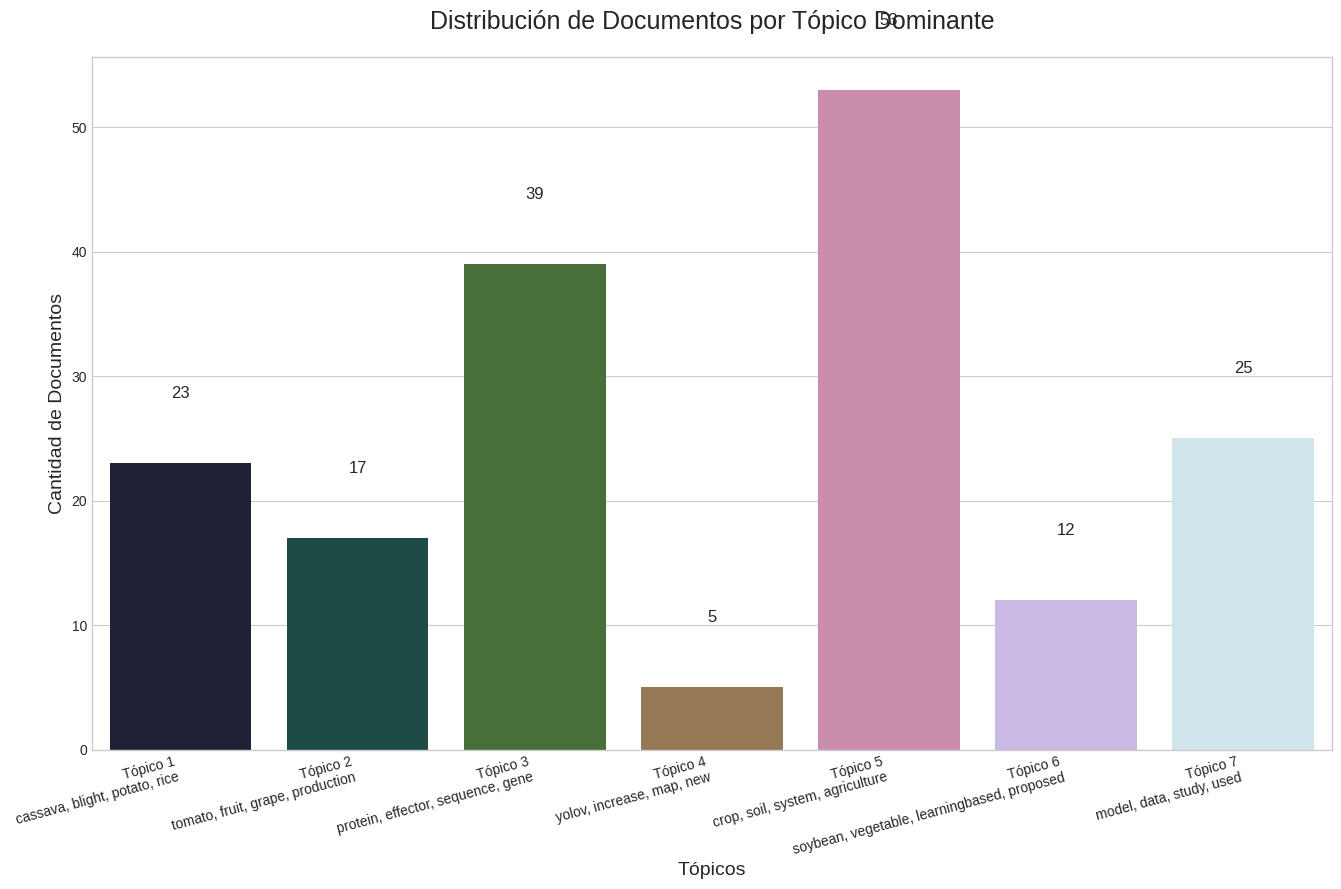

In [ ]:
# --- 4. Contar Documentos por Tópico y Crear Gráfico ---

# Contar el número de documentos para cada tópico
topic_distribution_counts = df['dominant_topic'].value_counts().sort_index()

# Crear etiquetas más descriptivas para cada tópico
topic_labels = []
for i in range(num_topics):
    # Obtener las 4 palabras clave más importantes para el tópico i
    keywords = lda_model.show_topic(i, topn=4)
    # Formatear las palabras clave en una cadena
    label = f"Tópico {i+1}\n" + ", ".join([word for word, prop in keywords])
    topic_labels.append(label)

# Visualización del gráfico de barras
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(16, 9))

ax = sns.barplot(x=topic_distribution_counts.index, y=topic_distribution_counts.values, palette="cubehelix")

# Añadir el número de documentos encima de cada barra
for index, value in enumerate(topic_distribution_counts.values):
    ax.text(index, value + 5, str(value), ha='center', va='bottom', fontsize=12)

plt.title('Distribución de Documentos por Tópico Dominante', fontsize=18, pad=20)
plt.xlabel('Tópicos', fontsize=14)
plt.ylabel('Cantidad de Documentos', fontsize=14)
ax.set_xticklabels(topic_labels, rotation=15, ha="right", fontsize=10)

In [ ]:
#--- 3. Asignar Tópico Dominante y Probabilidad a cada Documento ---

def get_dominant_topic_and_prob(doc_bow):
    # Obtener la distribución de tópicos para un documento
    topic_distribution = lda_model.get_document_topics(doc_bow, minimum_probability=0.0)
    # Encontrar el tópico con la probabilidad más alta
    dominant_topic = sorted(topic_distribution, key=lambda x: x[1], reverse=True)[0]
    topic_id = dominant_topic[0]
    topic_prob = dominant_topic[1]
    return topic_id, topic_prob

# Aplicar la función a todo el corpus para obtener el tópico dominante y su probabilidad
# Usamos zip(*...) para separar las dos listas (IDs y probabilidades)
dominant_topics, topic_probabilities = zip(*[get_dominant_topic_and_prob(doc) for doc in corpus])

# --- 4. Añadir las Nuevas Columnas al DataFrame ---
df['dominant_topic'] = dominant_topics
df['topic_probability'] = topic_probabilities

print("Columnas 'dominant_topic' y 'topic_probability' añadidas.")

# --- 5. (Opcional pero recomendado) Crear una columna con etiquetas legibles ---
# Crear un diccionario para mapear el ID del tópico a un nombre descriptivo
topic_labels = {}
for i in range(num_topics):
    # Tomar las 3 palabras clave más importantes para el tópico i
    keywords = lda_model.show_topic(i, topn=3)
    # Formatear las palabras clave en una cadena legible
    label = f"Tópico {i+1}: " + ", ".join([word for word, prop in keywords])
    topic_labels[i] = label

# Mapear los IDs a las etiquetas legibles
df['topic_label'] = df['dominant_topic'].map(topic_labels)
print("Columna 'topic_label' con nombres descriptivos añadida.")


# --- 6. Mostrar el resultado ---
print("\n--- Vista previa del DataFrame con las nuevas columnas ---")
# Mostramos las columnas relevantes para verificar el resultado
print(df[['title', 'dominant_topic', 'topic_probability', 'topic_label']].head(10))

# También puedes ver la distribución de documentos por tópico
print("\n--- Distribución de documentos por tópico ---")
print(df['topic_label'].value_counts())

Columnas 'dominant_topic' y 'topic_probability' añadidas.
Columna 'topic_label' con nombres descriptivos añadida.

--- Vista previa del DataFrame con las nuevas columnas ---
                                               title  dominant_topic  \
0  Discovery of antimicrobial peptides from Bacil...               2   
1  Integrated phenotypic analysis, predictive mod...               2   
2  Mid-FTIR and machine learning for predicting f...               4   
3  Gaussian regressed generative adversarial netw...               0   
4  In silico prediction of variant effects: promi...               2   
5  PlantPathoPPI: An Ensemble-based Machine Learn...               2   
6  Monochromatic LeafAdaptNet (MLAN): an adaptive...               4   
7  Integrating multi-omics and machine learning f...               2   
8  Cauliflower leaf diseases: A computer vision d...               6   
9  Revolutionizing in vitro cultivation: machine ...               3   

   topic_probability             

In [ ]:
# --- 4. Exportar el DataFrame a CSV y XLSX ---

# Opción 1: Exportar a CSV
# Es rápido y bueno para la compatibilidad. Usaremos '|' como separador.
csv_output_path = './referencias_con_topicos.csv'
try:
    df.to_csv(csv_output_path, sep='|', index=False, encoding='utf-8')
    print(f"\n¡Éxito! DataFrame exportado a CSV en: {csv_output_path}")
except Exception as e:
    print(f"\nOcurrió un error al guardar en CSV: {e}")


# Opción 2: Exportar a Excel (XLSX)
# Es más amigable para visualizar, pero puede generar archivos grandes.
# Nota: Necesitarás instalar la librería openpyxl: pip install openpyxl
xlsx_output_path = './referencias_con_topicos.xlsx'
try:
    # Para evitar archivos muy grandes, es buena idea seleccionar las columnas más importantes.
    # Si quieres todas las columnas, simplemente usa df.to_excel(...)
    columns_to_export = [
        'DOI', 'title', 'authors', 'year', 'source_title', 
        'dominant_topic', 'topic_probability', 'topic_label', 'abstract'
    ]
    
    df_to_export = df[columns_to_export]
    df_to_export.to_excel(xlsx_output_path, index=False, engine='openpyxl')
    print(f"¡Éxito! DataFrame exportado a Excel en: {xlsx_output_path}")
except ImportError:
    print("\nPara exportar a Excel, por favor instala la librería 'openpyxl' ejecutando: pip install openpyxl")
except Exception as e:
    print(f"\nOcurrió un error al guardar en Excel: {e}")


¡Éxito! DataFrame exportado a CSV en: ./referencias_con_topicos.csv
¡Éxito! DataFrame exportado a Excel en: ./referencias_con_topicos.xlsx


# Analisis descriptivo y bibliometrico

In [ ]:
# validaciones 
sns.set(style="whitegrid", rc={"figure.dpi":150})

# Asegurar columnas mínimas (si faltan, crearlas vacías para evitar errores)
for c in ["fuente","authors","author_full_names","title","year","source_title","cited_by",
          "DOI","abstract","author_Keywords","index_keywords","document_type","open_access"]:
    if c not in df.columns:
        df[c] = np.nan

# info rápida
print("Registros:", df.shape[0])

Registros: 174


In [ ]:
df[["title","year","source_title"]].head(5)

title  year  \
0  Discovery of antimicrobial peptides from Bacil...  2025   
1  Integrated phenotypic analysis, predictive mod...  2025   
2  Mid-FTIR and machine learning for predicting f...  2025   
3  Gaussian regressed generative adversarial netw...  2025   
4  In silico prediction of variant effects: promi...  2025   

                                        source_title  
0  Chemical and Biological Technologies in Agricu...  
1                                  BMC Plant Biology  
2                                Analytical Sciences  
3           Biomedical Signal Processing and Control  
4                   Theoretical and Applied Genetics

In [ ]:
print(df.isnull().sum().sort_values(ascending=False).head(20))

author_Keywords            174
cuartil                    174
issn                       174
open_access                102
art                         95
page_end                    91
page_start                  89
h_index_revista             39
scopus_author_id            19
author_full_names           19
EID                         19
publication_stage           19
author_orcid                17
link                        16
h_index_autor                2
index_keywords_cleaned       0
abstract_cleaned             0
author_keywords_cleaned      0
author_full_names_list       0
authors_list                 0
dtype: int64


In [ ]:
# calidad de metadatos
# Un resumen rápido
print(df.describe(include='all').T[['count','unique']].head(30))

                   count unique
fuente               174      3
authors              174    174
author_full_names    155    155
scopus_author_id     155    155
title                174    174
year               174.0    NaN
source_title         174    112
volume             174.0   82.0
issue              174.0   23.0
art                   79     79
page_start          85.0   74.0
page_end            83.0   73.0
page_count         174.0    NaN
cited_by           174.0    NaN
DOI                  174    174
link                 158    158
abstract             174    173
author_keywords      174    170
index_keywords       174    144
document_type        174      7
publication_stage    155      2
open_access           72     11
source               174      3
EID                  155    155
h_index_autor        172    172
h_index_revista    135.0    NaN
cuartil              0.0    NaN
author_orcid         157    157
issn                 0.0    NaN
title_cleaned        174    174


In [ ]:
# % de registros con DOI/abstract/keywords
for col in ["DOI","abstract","author_Keywords","author_full_names"]:
    pct = df[col].notna().sum()/len(df)*100
    print(f"{col}: {df[col].notna().sum()} ({pct:.1f}%)")

DOI: 174 (100.0%)
abstract: 174 (100.0%)
author_Keywords: 0 (0.0%)
author_full_names: 155 (89.1%)


In [ ]:
#fuente
# Preferir 'source_title' si está, sino 'fuente'
src_col = "source_title" if "source_title" in df.columns else "fuente"
top_sources = df[src_col].fillna("Unknown").value_counts().head(30)
top_sources.to_csv("top_sources.csv")

# Índice de concentración (HHI: suma de cuadrados de shares, entre 0 y 1)
shares = df[src_col].value_counts(normalize=True)
hhi = (shares**2).sum()
print("HHI (0-1):", hhi)

HHI (0-1): 0.02523450918219051


/tmp/ipykernel_3685393/1564415411.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='ngram', x='freq', data=ngram_df, palette='mako')


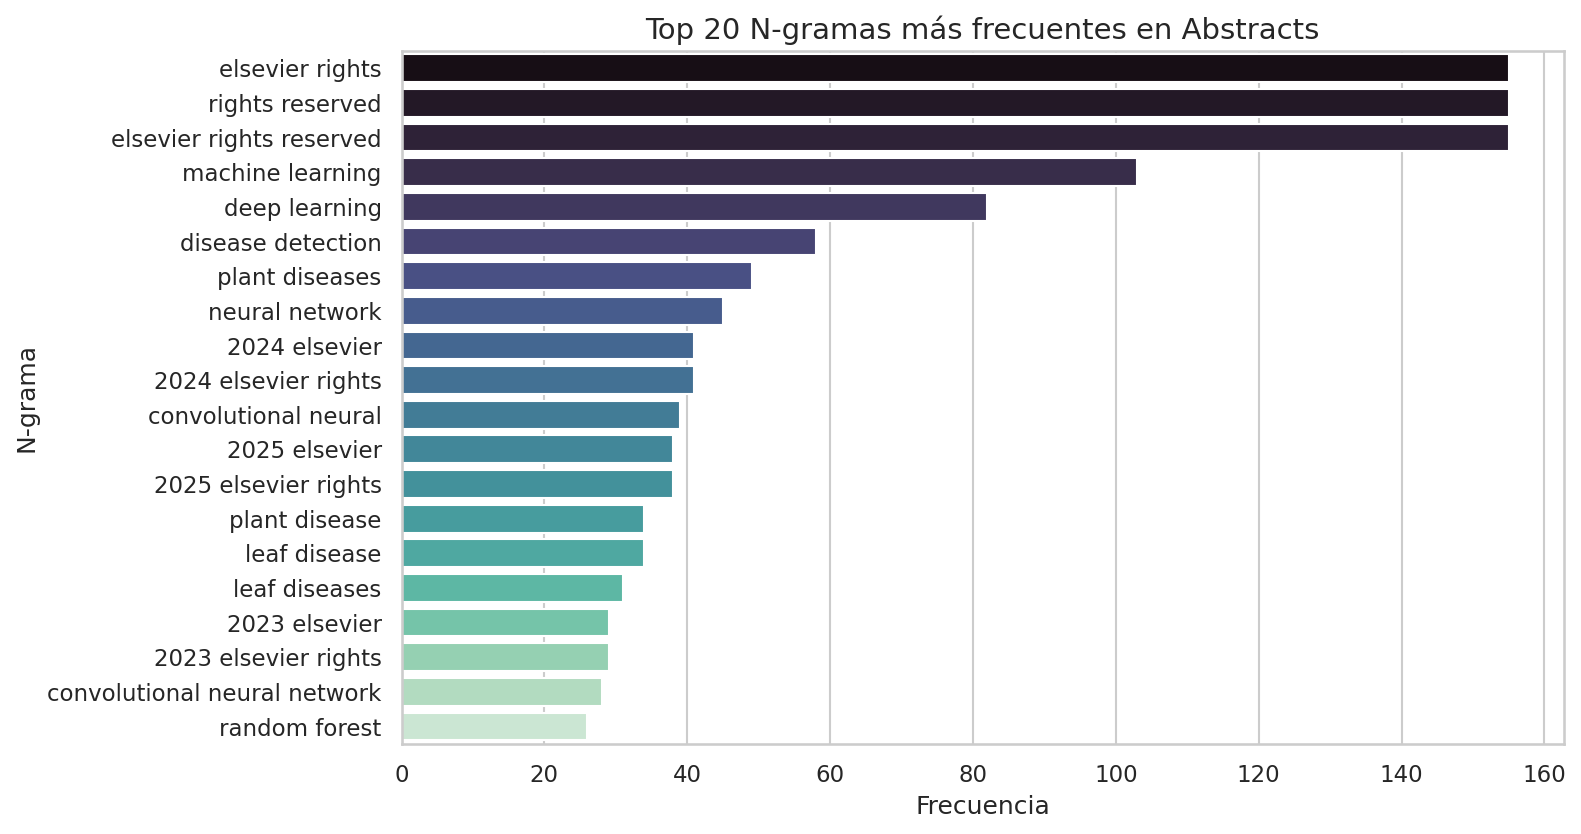

In [ ]:
#N-gramas y términos en Abstracts
#Objetivo: encontrar frases comunes y términos recurrentes en los resúmenes.
# Unir todos los abstracts
abstracts = df['abstract'].fillna('').str.lower()

# N-gramas (2 y 3 palabras)
vectorizer = CountVectorizer(ngram_range=(2,3), stop_words='english').fit(abstracts)
X = vectorizer.transform(abstracts)
sum_words = X.sum(axis=0)

ngrams_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
ngrams_freq = sorted(ngrams_freq, key=lambda x: x[1], reverse=True)[:20]

# DataFrame
ngram_df = pd.DataFrame(ngrams_freq, columns=['ngram', 'freq'])

# Visualizar
plt.figure(figsize=(10,6))
sns.barplot(y='ngram', x='freq', data=ngram_df, palette='mako')
plt.title("Top 20 N-gramas más frecuentes en Abstracts", fontsize=14)
plt.xlabel("Frecuencia")
plt.ylabel("N-grama")
plt.show()

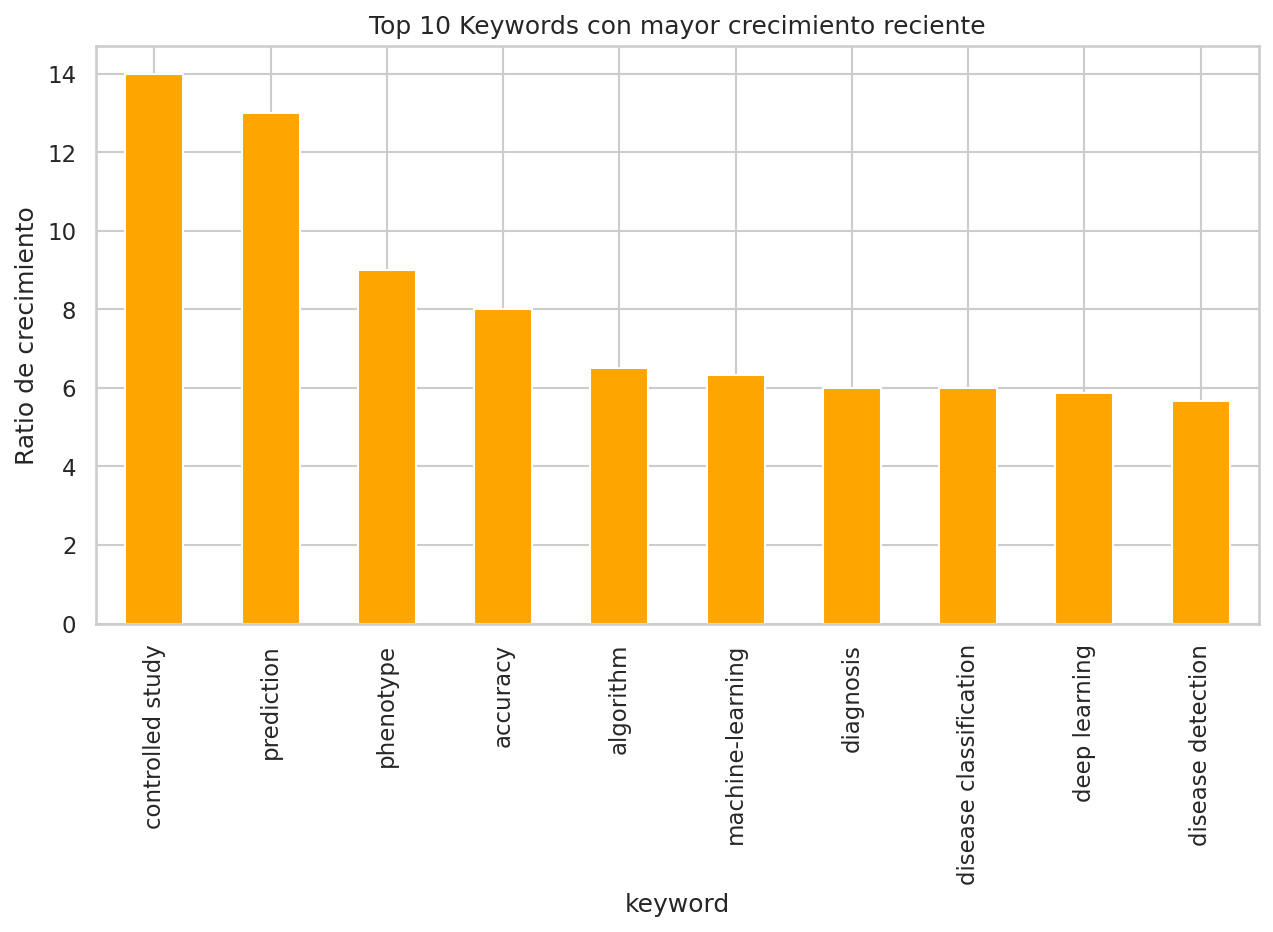

In [ ]:
# Normalizamos año
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df = df.dropna(subset=['year'])

# Expandir keywords con año
rows = []
for _, row in df.iterrows():
    kws = (str(row['author_Keywords']) + ';' + str(row['index_keywords'])).split(';')
    for kw in kws:
        kw_clean = kw.strip().lower()
        if kw_clean:
            rows.append({'year': int(row['year']), 'keyword': kw_clean})

kw_year_df = pd.DataFrame(rows)

# Contar frecuencia por año
trend = kw_year_df.groupby(['keyword', 'year']).size().reset_index(name='count')

# Calcular crecimiento relativo (últimos 3 años vs resto)
latest_years = trend['year'].max() - 2
growth = (
    trend[trend['year'] >= latest_years]
    .groupby('keyword')['count'].sum()
    / trend[trend['year'] < latest_years]
    .groupby('keyword')['count'].sum()
)

growth = growth.sort_values(ascending=False).dropna().head(10)

# Visualizar crecimiento
growth.plot(kind='bar', figsize=(10,5), color='orange')
plt.title("Top 10 Keywords con mayor crecimiento reciente")
plt.ylabel("Ratio de crecimiento")
plt.show()

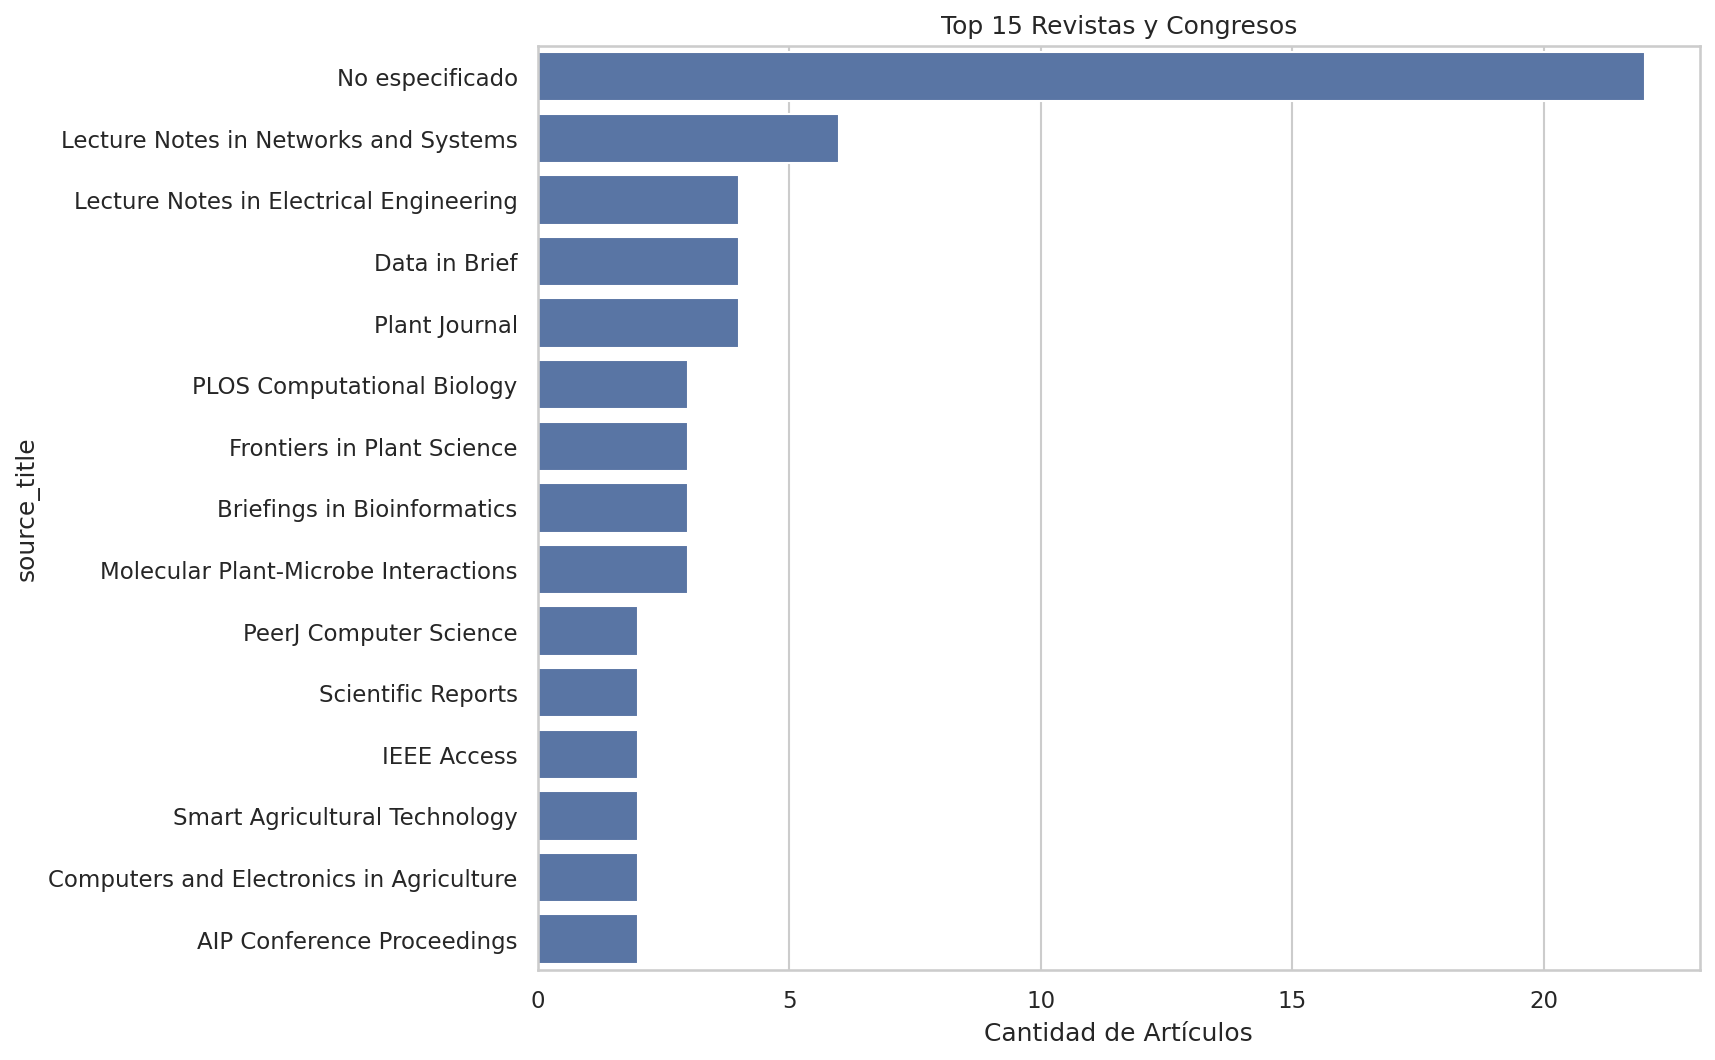

In [ ]:
# Contar las 15 fuentes más comunes
top_sources = df['source_title'].value_counts().nlargest(15)

# Visualizar
plt.figure(figsize=(10, 8))
sns.barplot(x=top_sources.values, y=top_sources.index, orient='h')
plt.title('Top 15 Revistas y Congresos')
plt.xlabel('Cantidad de Artículos')
plt.show()